#                                                           Improving Delivery Rate Performance on Olist e-Commerce
Alpha Team - DTIDSOL-02

- Josephine
- Rio
- Widya


### **Contents**

1. Business Problem Understanding
2. Data Cleaning and Understanding
3. EDA
4. Data analysis
5. Summary
6. Conclusion 
7. Limitation
8. Recommendations

****

# Problem Statement

Background and aim of analysis
Business problem identification 

# Data Understanding & Cleaning

## Import Libraries & Datasets

In [702]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind, kstest, spearmanr
import statsmodels.api as sm
import os
import missingno as msno

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_colwidth', None)

In [703]:
# List of date columns for each Olist dataset
# This dictionary maps each dataset filename to a list of columns that should be parsed as dates.
date_cols = {
    'olist_orders_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
    'olist_order_items_dataset.csv': [
        'shipping_limit_date',
    ],
    'olist_order_reviews_dataset.csv': [
        'review_creation_date',
        'review_answer_timestamp',
    ],
    # The following datasets have NO date columns:
    # 'olist_customers_dataset.csv'
    # 'olist_geolocation_dataset.csv'
    # 'olist_order_payments_dataset.csv'
    # 'olist_products_dataset.csv'
    # 'olist_sellers_dataset.csv'
    # 'product_category_name_translation.csv'
}

def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    # Extract just the filename, e.g., 'olist_orders_dataset.csv'
    filename = os.path.basename(path)
    # Get the correct date columns for this file, or an empty list
    parse_dates = date_cols.get(filename, [])
    # Read the CSV, parsing the specified date columns (if any)
    return pd.read_csv(path, parse_dates=parse_dates)

Load original (raw) datasets:

In [704]:
original_df_orders           = read_olist_csv('../data/original_data/olist_orders_dataset.csv')
original_df_customers        = read_olist_csv('../data/original_data/olist_customers_dataset.csv')
original_df_order_items      = read_olist_csv('../data/original_data/olist_order_items_dataset.csv')
original_df_order_payments   = read_olist_csv('../data/original_data/olist_order_payments_dataset.csv')
original_df_reviews          = read_olist_csv('../data/original_data/olist_order_reviews_dataset.csv')
original_df_products         = read_olist_csv('../data/original_data/olist_products_dataset.csv')
original_df_prod_cat_tr      = read_olist_csv('../data/original_data/product_category_name_translation.csv')
original_df_sellers          = read_olist_csv('../data/original_data/olist_sellers_dataset.csv')
original_df_geolocation      = read_olist_csv('../data/original_data/olist_geolocation_dataset.csv')

## Orders Dataset

In [705]:
# Load the orders dataset:
original_df_orders.head(10)

order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18         
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   delivered    2018-07-24 20:41:37    2018-07-26 03:24:27     2018-07-26 14:31:00           2018-08-07 15:27:45                2018-08-13         
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   delivered    2018-08-08 08:38:49    2018-08-08 08:55:23     2018-08-08 13:50:00           2018-08-17 18:06:29                2018-09-04         
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   delivered    2017-11-18 19:28:06    2017-11-18 19:45:59     2017-11-22 13:39:59           2017-12-02 00:28:42                2017-12-15         
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   delivered    2018-02-13 21:18:39    2018-02-13 22:20:29     2018-02-14 19:46:34           2018-02-16 18:17:02                2018-02-26         
5  a4591c265e18cb1dcee52889e2d8acc3  503740e9ca751ccdda7ba28e9ab8f608   delivered    2017-07-09 21:57:05    2017-07-09 22:10:13     2017-07-11 14:58:04           2017-07-26 10:57:55                2017-08-01         
6  136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a    invoiced    2017-04-11 12:22:08    2017-04-13 13:25:17                     NaT                           NaT                2017-05-09         
7  6514b8ad8028c9f2cc2374ded245783f  9bdf08b4b3b52b5526ff42d37d47f222   delivered    2017-05-16 13:10:30    2017-05-16 13:22:11     2017-05-22 10:07:46           2017-05-26 12:55:51                2017-06-07         
8  76c6e866289321a7c93b82b54852dc33  f54a9f0e6b351c431402b8461ea51999   delivered    2017-01-23 18:29:09    2017-01-25 02:50:47     2017-01-26 14:16:31           2017-02-02 14:08:10                2017-03-06         
9  e69bfb5eb88e0ed6a785585b27e16dbf  31ad1d1b63eb9962463f764d4e6e0c9d   delivered    2017-07-29 11:55:02    2017-07-29 12:05:32     2017-08-10 19:45:24           2017-08-16 17:14:30                2017-08-23

| Column Name                    | Description                                                                 |
|-------------------------------|-----------------------------------------------------------------------------|
| `order_id`                    | Unique identifier for each order.                                           |
| `customer_id`                 | Unique identifier for the customer who placed the order.                    |
| `order_status`                | Current status of the order (e.g., delivered, shipped, etc.).     |
| `order_purchase_timestamp`    | Date and time when the order was placed.                                    |
| `order_approved_at`           | Date and time when the order was approved for processing.                   |
| `order_delivered_carrier_date`| Date the order was handed over to the logistics/delivery carrier.           |
| `order_delivered_customer_date`| Date the order was delivered to the customer.                              |
| `order_estimated_delivery_date`| Estimated delivery date promised to the customer at the time of purchase.  |


In [706]:
original_df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [707]:
original_df_orders.describe()

order_purchase_timestamp          order_approved_at         order_delivered_carrier_date  order_delivered_customer_date  order_estimated_delivery_date 
count                          99441                          99281                          97658                          96476                          99441
mean   2017-12-31 08:43:12.776581120  2017-12-31 18:35:24.098800128  2018-01-04 21:49:48.138278656  2018-01-14 12:09:19.035542272  2018-01-24 03:08:37.730111232
min              2016-09-04 21:15:19            2016-09-15 12:16:38            2016-10-08 10:34:01            2016-10-11 13:46:32            2016-09-30 00:00:00
25%              2017-09-12 14:46:19            2017-09-12 23:24:16  2017-09-15 22:28:50.249999872  2017-09-25 22:07:22.249999872            2017-10-03 00:00:00
50%              2018-01-18 23:04:36            2018-01-19 11:36:13            2018-01-24 16:10:58     2018-02-02 19:28:10.500000            2018-02-15 00:00:00
75%              2018-05-04 15:42:16            2018-05-04 20:35:10            2018-05-08 13:37:45  2018-05-15 22:48:52.249999872            2018-05-25 00:00:00
max              2018-10-17 17:30:18            2018-09-03 17:40:06            2018-09-11 19:48:28            2018-10-17 13:22:46            2018-11-12 00:00:00

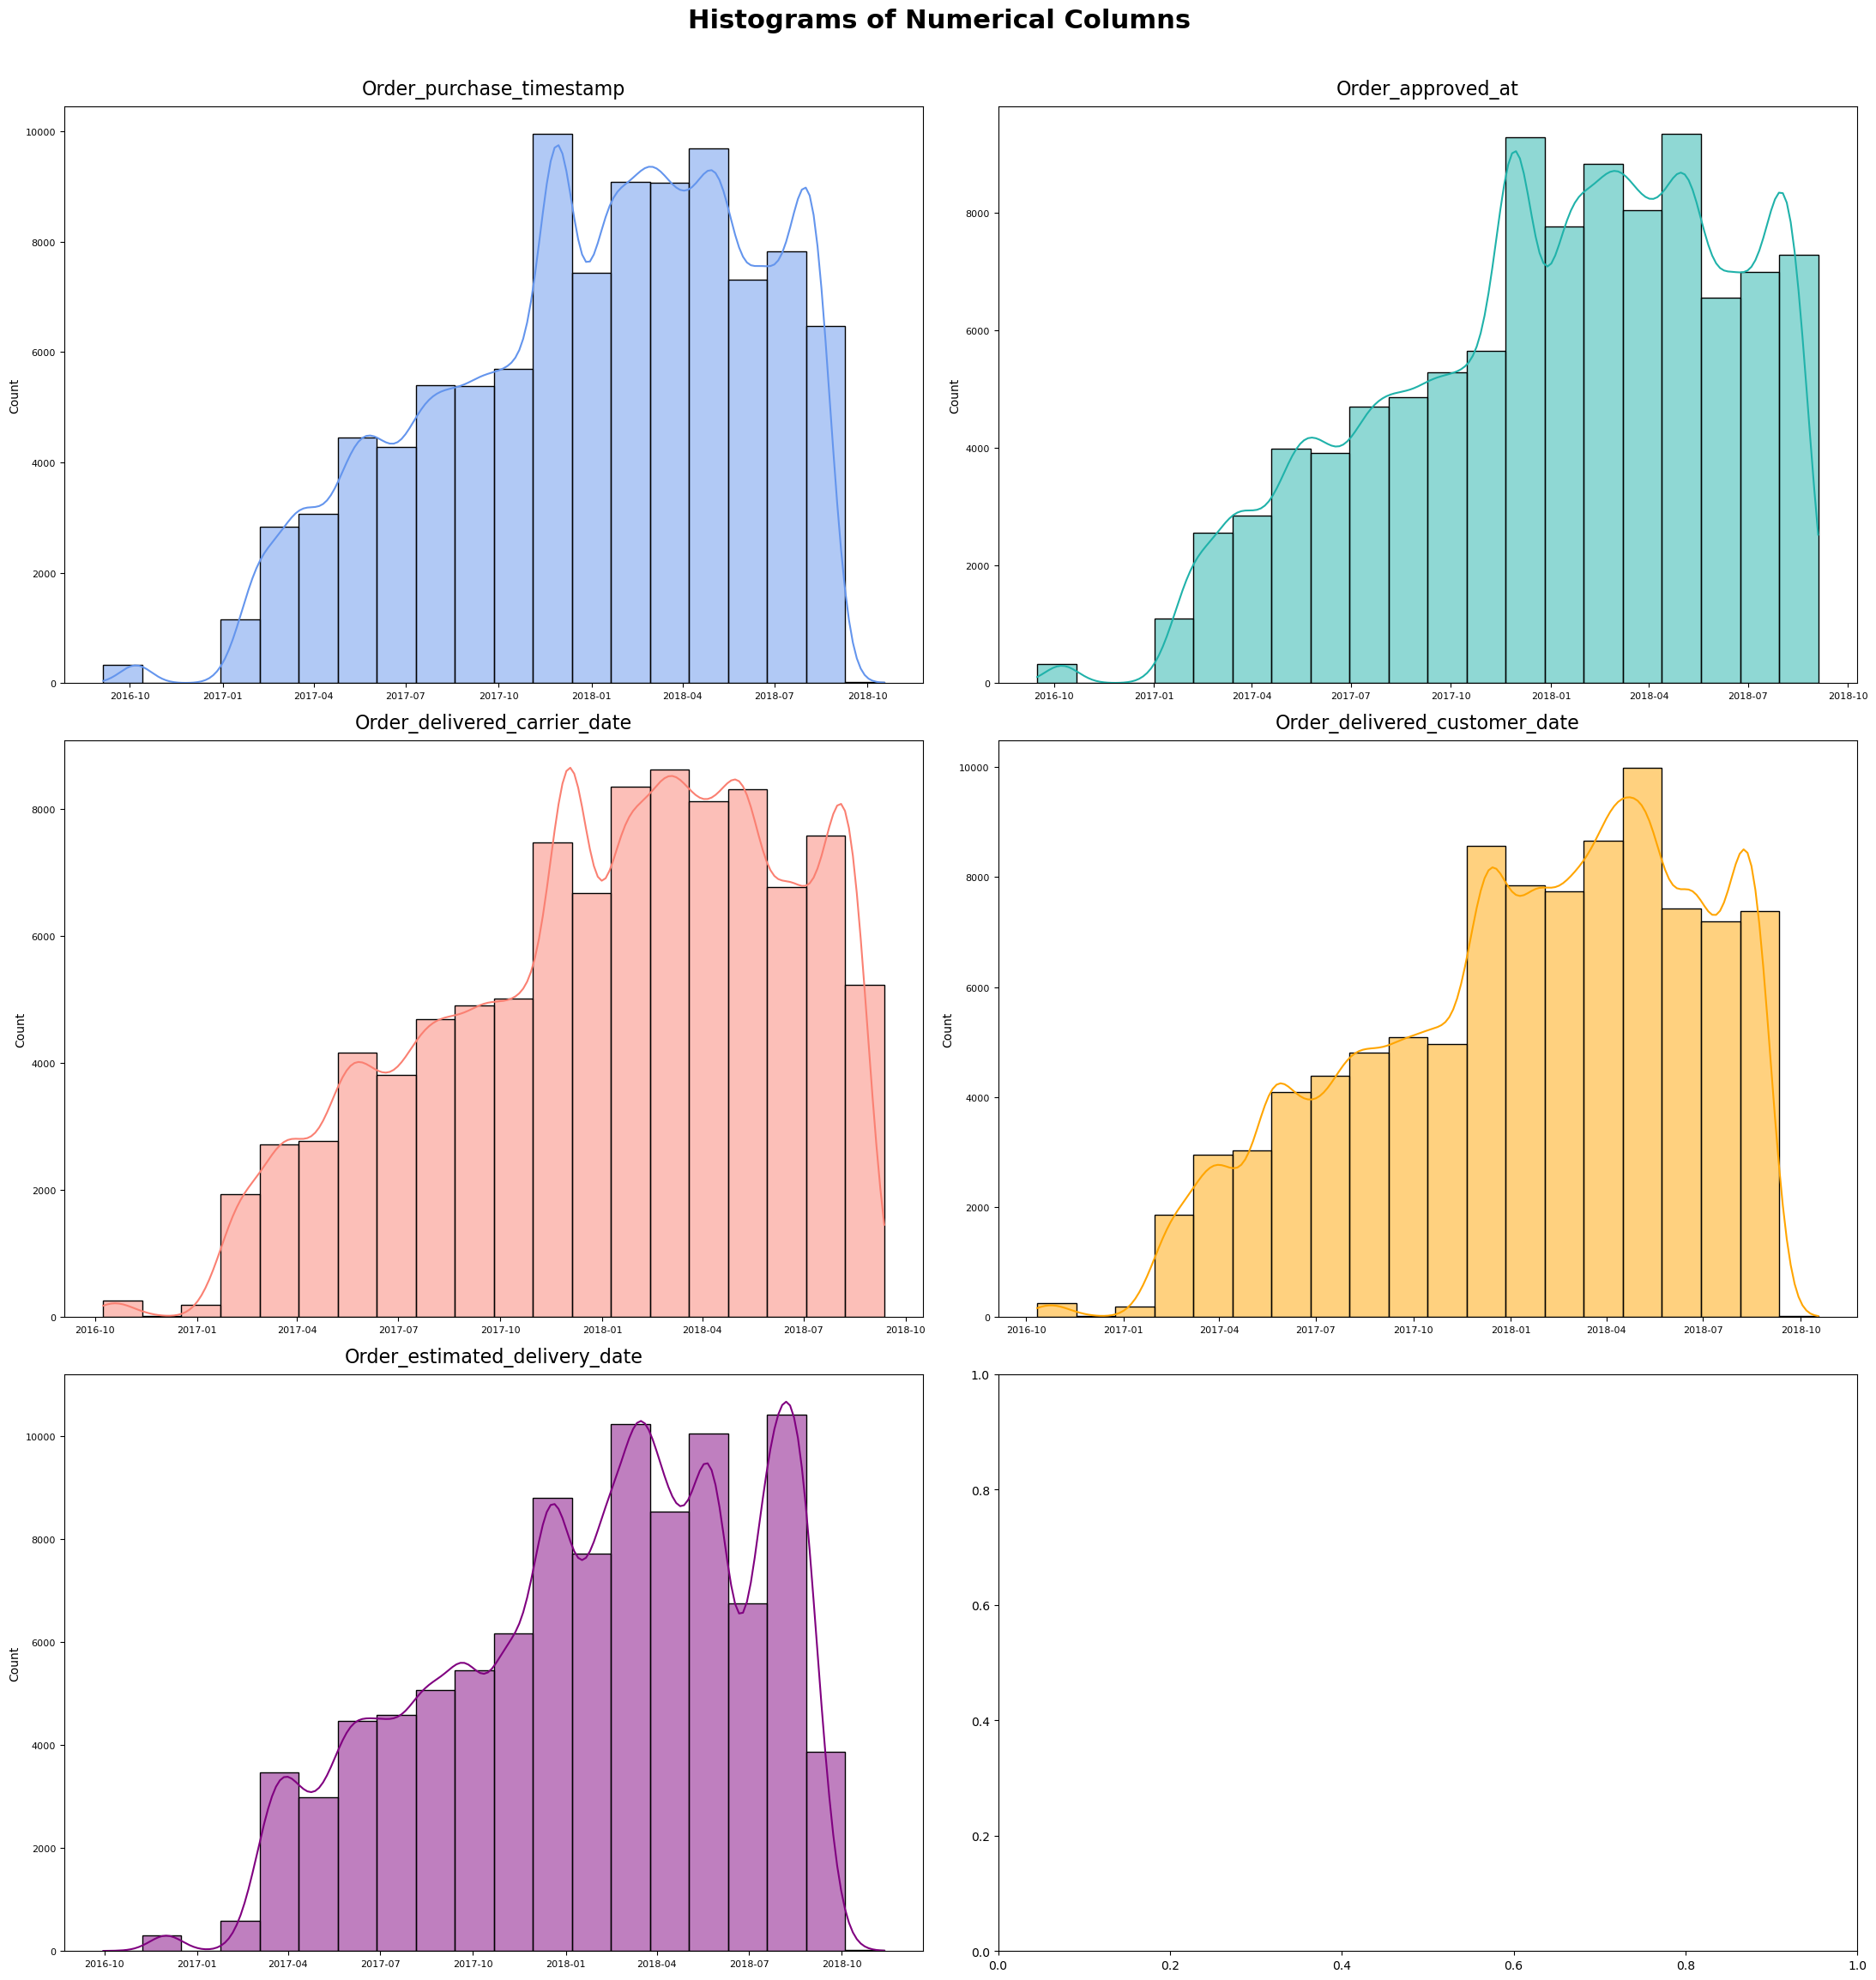

In [708]:
# data distribution 

# Filter only numerical columns (float and int)
onlynumeric_columns = original_df_orders.select_dtypes(include=['datetime64[ns]']).columns.to_list()

# Calculate the number of rows and columns needed for the plots
n_plots = len(onlynumeric_columns)
n_rows = int(np.ceil(n_plots / 2)) #4colums

# Create the subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(22, 8 * n_rows))
axes = axes.flatten()

# Colors of the histogram
colors = ['cornflowerblue', 'lightseagreen', 'salmon', 'orange', 'purple', 'navy', 'deeppink', 'brown','olivedrab']

# Plot histograms for each numeric column with different colors
for i, column in enumerate(onlynumeric_columns):
    color_index = i % len(colors)  
    sns.histplot(data=original_df_orders, x=column, kde=True, bins=20, ax=axes[i], color=colors[color_index])
    axes[i].set_title(column.capitalize(), fontsize=16, pad=10)  
    axes[i].set_xlabel('')  
    axes[i].set_ylabel('Count') 
    axes[i].tick_params(axis='both', labelsize=8)  

plt.suptitle('Histograms of Numerical Columns', fontsize=22, fontweight='bold')

plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()


In [709]:
summary = []

for col in original_df_orders.columns:
    unique_vals = original_df_orders[col].dropna().unique()
    summary.append({
        'Column': col,
        'Unique Count': len(unique_vals),
        'Unique Values': unique_vals
    })

df_summary = pd.DataFrame(summary)
df_summary

Column              Unique Count  \
0                       order_id      99441      
1                    customer_id      99441      
2                   order_status          8      
3       order_purchase_timestamp      98875      
4              order_approved_at      90733      
5   order_delivered_carrier_date      81018      
6  order_delivered_customer_date      95664      
7  order_estimated_delivery_date        459      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Unique Values                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
0  [e481f51cbdc54678b7cc49136f2d6af7, 53cdb2fc8bc7dce0b6741e2150273451, 47770eb9100c2d0c44946d9cf07ec65d, 949d5b44dbf5de918fe9c16f97b45f8a, ad21c59c0840

In [710]:
# Unique order_status values:
print(original_df_orders['order_status'].unique())

['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']


In [711]:
# Get a sample row for each order_status value
status_examples = original_df_orders.groupby('order_status').first().reset_index()

# Create a display-friendly dataframe
display_df = pd.DataFrame()

for _, row in status_examples.iterrows():
    # Format the row data
    formatted_row = row.copy()
    
    # Format datetime columns to be more readable
    for col in row.index:
        if pd.api.types.is_datetime64_any_dtype(row[col]):
            formatted_row[col] = "N/A" if pd.isna(row[col]) else row[col].strftime('%Y-%m-%d %H:%M:%S')
    
    # Add the status name as a separate row for better visualization
    display_df = pd.concat([display_df, pd.DataFrame([formatted_row])])

# Display the dataframe with better formatting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Wider display
pd.set_option('display.colheader_justify', 'center')  # Center column headers

# create a more compact display focusing on key columns
compact_view = display_df[['order_status', 'order_purchase_timestamp', 'order_approved_at', 
                         'order_delivered_carrier_date', 'order_delivered_customer_date', 
                         'order_estimated_delivery_date']]

print("\n=== COMPACT ORDER STATUS EXAMPLES ===\n")
display(compact_view)


=== COMPACT ORDER STATUS EXAMPLES ===



order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date
0     approved   2017-02-06 20:18:17    2017-02-06 20:30:19                     NaT                           NaT                2017-03-01         
1     canceled   2018-08-04 14:29:27    2018-08-07 04:10:26     2018-01-29 22:33:25           2018-03-21 22:03:51                2018-08-14         
2      created   2017-12-05 01:07:52                    NaT                     NaT                           NaT                2018-01-11         
3    delivered   2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18         
4     invoiced   2017-04-11 12:22:08    2017-04-13 13:25:17                     NaT                           NaT                2017-05-09         
5   processing   2017-09-03 14:22:03    2017-09-03 14:30:09                     NaT                           NaT                2017-10-03         
6      shipped   2018-06-04 16:44:48    2018-06-05 04:31:18     2018-06-05 14:32:00                           NaT                2018-06-28         
7  unavailable   2017-11-16 15:09:28    2017-11-16 15:26:57                     NaT                           NaT                2017-12-05

In [712]:
# Count the number of orders that are not "delivered"
non_delivered_count = original_df_orders[original_df_orders['order_status'] != 'delivered'].shape[0]

# Get the percentage of non-delivered orders
total_orders = original_df_orders.shape[0]
non_delivered_percentage = (non_delivered_count / total_orders) * 100

# Count by each status type that isn't "delivered"
status_counts = original_df_orders[original_df_orders['order_status'] != 'delivered']['order_status'].value_counts()

print(f"Total orders: {total_orders}")
print(f"Non-delivered orders: {non_delivered_count} ({non_delivered_percentage:.2f}%)")
print("\nBreakdown by status:")
display(status_counts)

Total orders: 99441
Non-delivered orders: 2963 (2.98%)

Breakdown by status:


order_status
shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: count, dtype: int64

For our project scope, we are only interested in "Delivered" orders since we are looking to evaluate the delivery performance

In [713]:
# Keep only delivered orders:
df_orders_delivered = original_df_orders[original_df_orders['order_status'] == 'delivered'].copy()
df_orders_delivered.shape

(96478, 8)

In [714]:
df_orders_delivered.duplicated().sum()

0

In [715]:
df_orders_delivered.drop(columns='order_id').duplicated().sum()

0

In [716]:
df_orders_delivered.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

# EDA Preparation

Load cleaned datasets

In [717]:
cleaned_delivered_df_orders           = read_olist_csv('../data/cleaned_data/olist_orders_dataset.csv')
cleaned_df_customers        = read_olist_csv('../data/cleaned_data/olist_customers_dataset.csv')
cleaned_delivered_df_order_items      = read_olist_csv('../data/cleaned_data/olist_order_items_dataset.csv')
cleaned_delivered_df_order_payments   = read_olist_csv('../data/cleaned_data/olist_order_payments_dataset.csv')
cleaned_delivered_df_reviews          = read_olist_csv('../data/cleaned_data/olist_order_reviews_dataset.csv')
cleaned_df_products         = read_olist_csv('../data/cleaned_data/olist_products_dataset.csv')
cleaned_df_prod_cat_tr      = read_olist_csv('../data/cleaned_data/product_category_name_translation.csv')
cleaned_df_sellers          = read_olist_csv('../data/cleaned_data/olist_sellers_dataset.csv')
cleaned_df_geolocation      = read_olist_csv('../data/cleaned_data/olist_geolocation_dataset.csv')

Merge all datasets

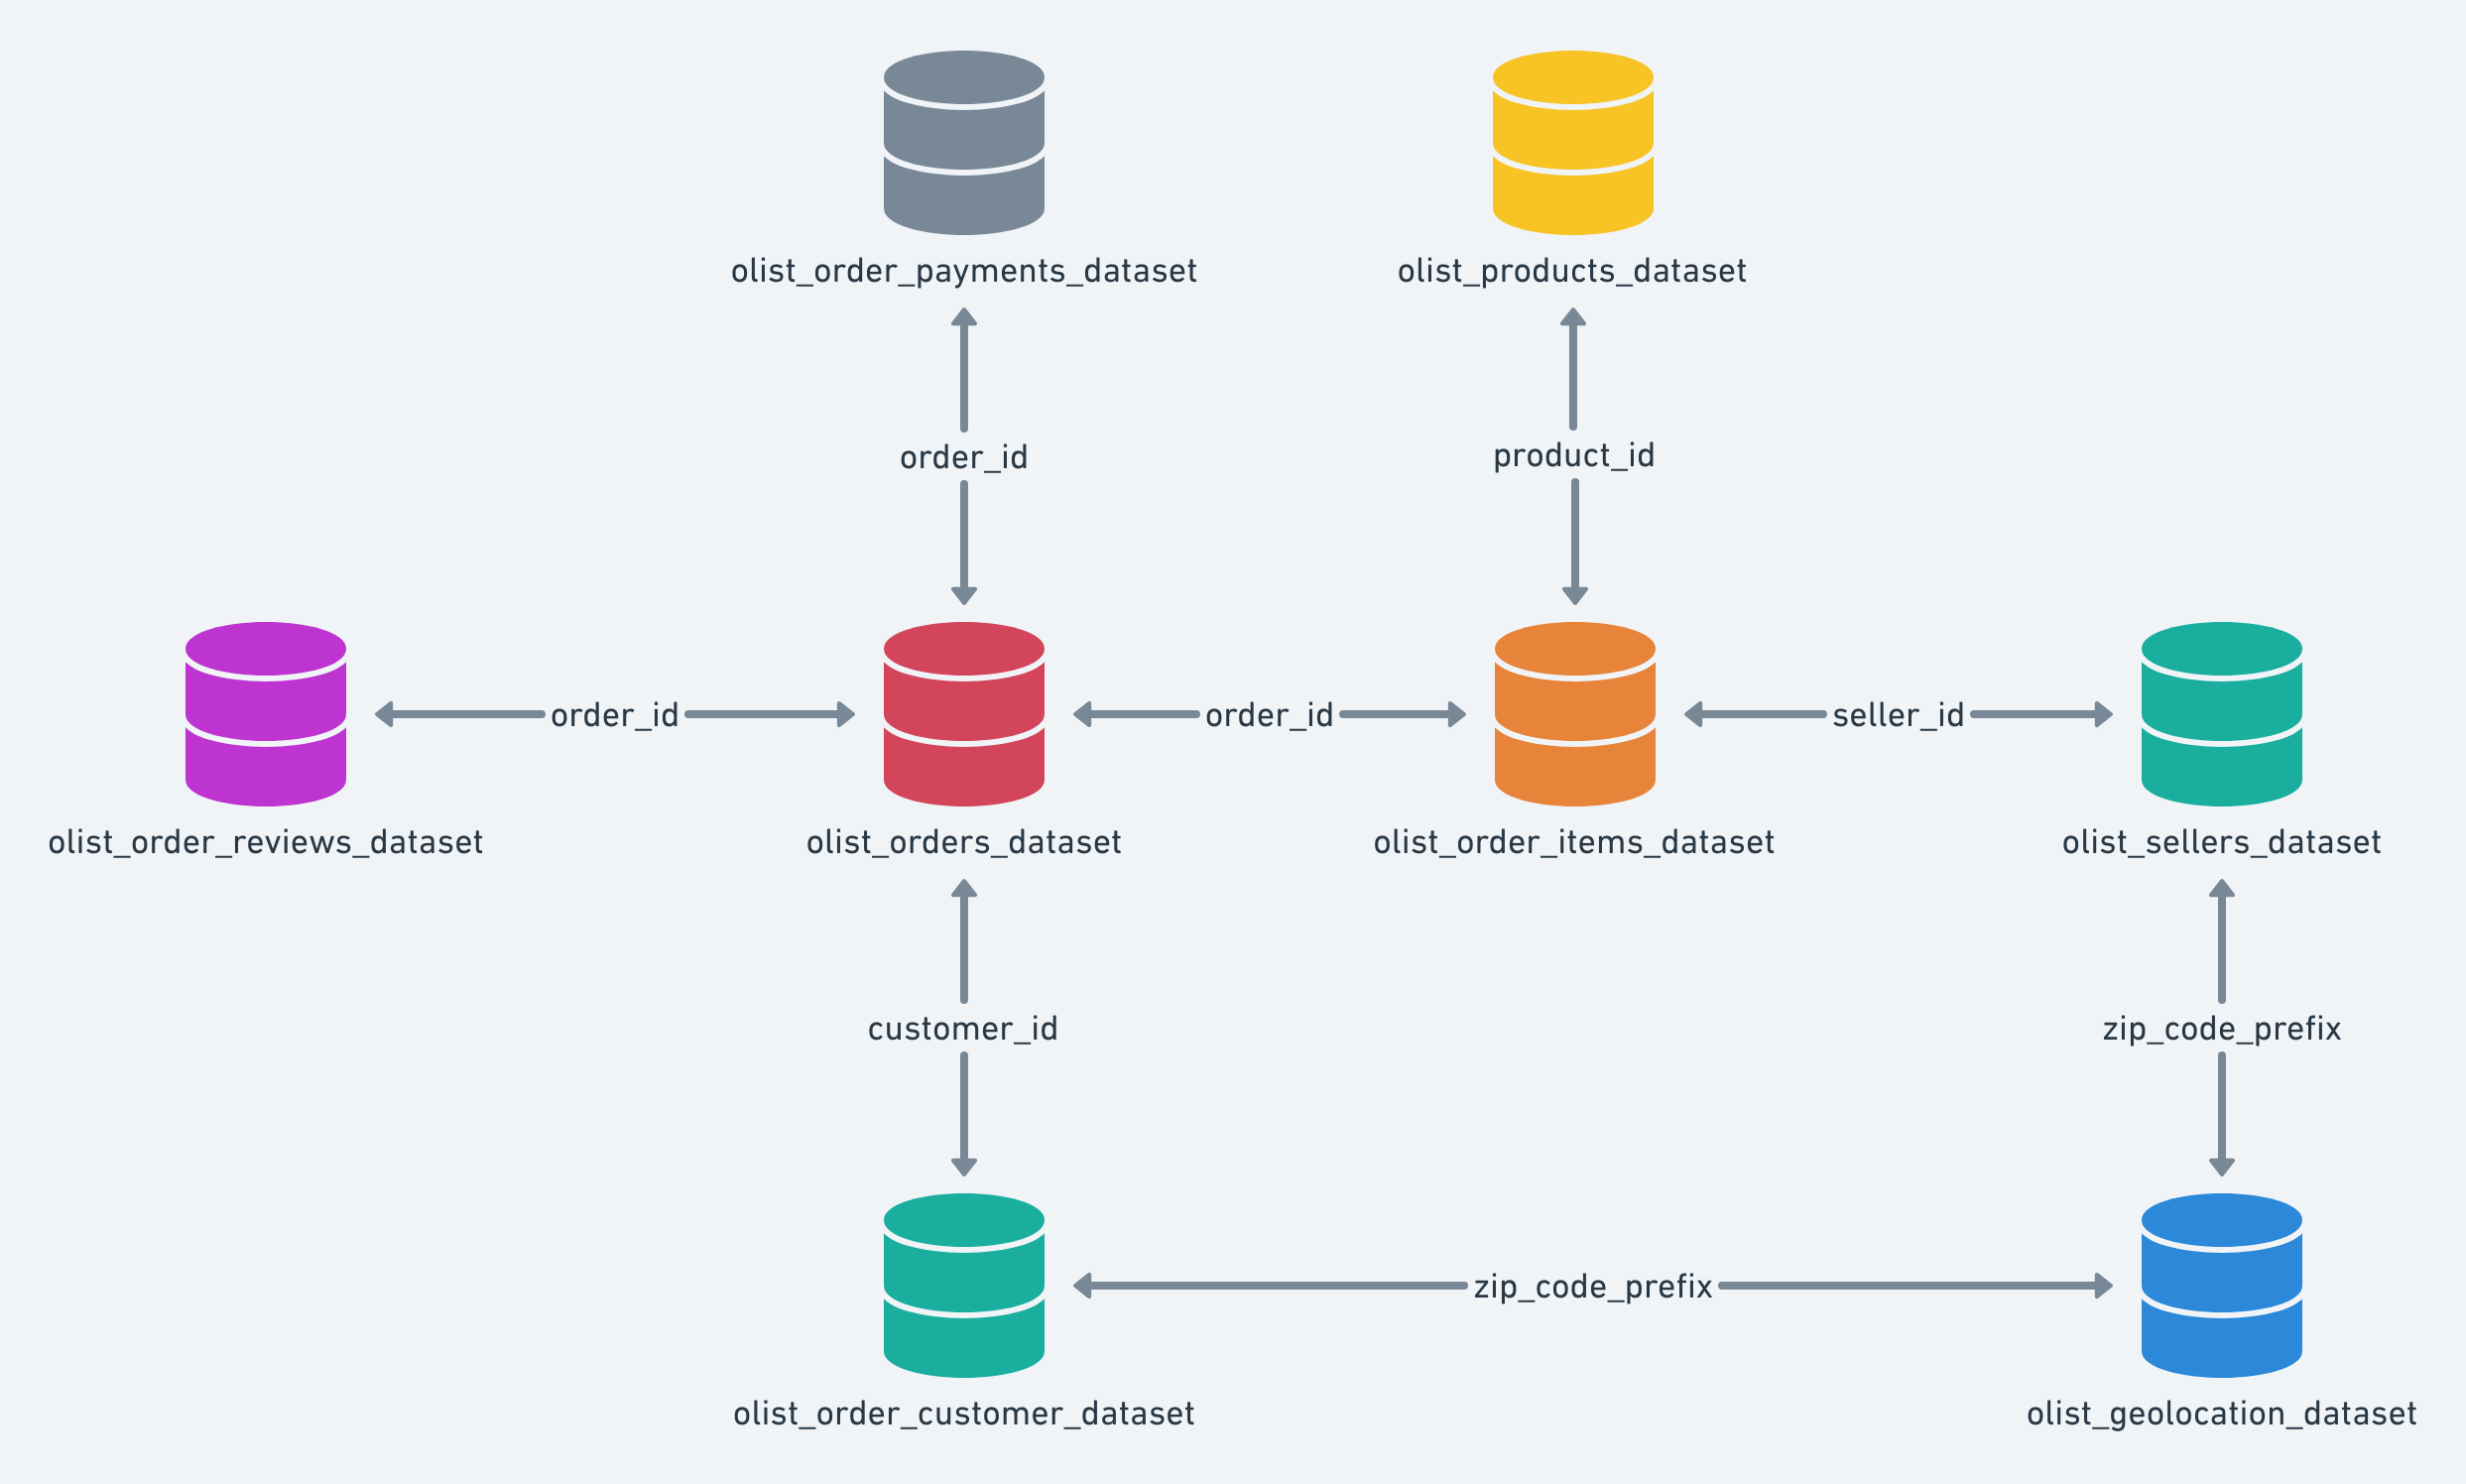

Orders with Customers

In [718]:
# Merge orders + customers (1:1)
merged_orders_customers = cleaned_delivered_df_orders.merge(
    cleaned_df_customers,
    on='customer_id',
    how='left',
    indicator=True
)
print("orders⇄customers:", merged_orders_customers['_merge'].value_counts())
assert (merged_orders_customers['_merge'] == 'both').all(), "⚠️ Some orders missing customers!"
merged_orders_customers.drop(columns=['_merge'], inplace=True)

display(merged_orders_customers.head())

orders⇄customers: _merge
both          96282
left_only         0
right_only        0
Name: count, dtype: int64


order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix      customer_city       customer_state
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149                         sao paulo       SP      
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   delivered    2018-07-24 20:41:37    2018-07-26 03:24:27     2018-07-26 14:31:00           2018-08-07 15:27:45                2018-08-13           af07308b275d755c9edb36a90c618231            47813                         barreiras       BA      
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   delivered    2018-08-08 08:38:49    2018-08-08 08:55:23     2018-08-08 13:50:00           2018-08-17 18:06:29                2018-09-04           3a653a41f6f9fc3d2a113cf8398680e8            75265                        vianopolis       GO      
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   delivered    2017-11-18 19:28:06    2017-11-18 19:45:59     2017-11-22 13:39:59           2017-12-02 00:28:42                2017-12-15           7c142cf63193a1473d2e66489a9ae977            59296           sao goncalo do amarante       RN      
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   delivered    2018-02-13 21:18:39    2018-02-13 22:20:29     2018-02-14 19:46:34           2018-02-16 18:17:02                2018-02-26           72632f0f9dd73dfee390c9b22eb56dd6             9195                       santo andre       SP

In [719]:
merged_orders_customers.isna().sum()  # Check for any missing values in the merged DataFrame

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
dtype: int64

Order Items with Products

In [720]:
# Enrich order_items with products (1:1)
enriched_order_items = cleaned_delivered_df_order_items.merge(
    cleaned_df_products,
    on='product_id',
    how='left',
    indicator=True
)

print("order_items⇄products:", enriched_order_items['_merge'].value_counts())
# assert (enriched_order_items['_merge'] == 'both').all(), "⚠️ Some items missing products!"
# enriched_order_items.drop(columns=['_merge'], inplace=True)

display(enriched_order_items.head())

order_items⇄products: _merge
both          109936
left_only         17
right_only         0
Name: count, dtype: int64


order_id              order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name  product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm _merge
0  00010242fe8c5a6d1ba2dd792cb16214        1        4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202 2017-09-19 09:45:35   58.90      13.29               cool_stuff          58.0                     598.0                    4.0                650.0            28.0                9.0               14.0        both 
1  00018f77f2f0320c557190d7a144bdd3        1        e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36 2017-05-03 11:05:13  239.90      19.93                 pet_shop          56.0                     239.0                    2.0              30000.0            50.0               30.0               40.0        both 
2  000229ec398224ef6ca0657da4fc703e        1        c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d 2018-01-18 14:48:30  199.00      17.87         moveis_decoracao          59.0                     695.0                    2.0               3050.0            33.0               13.0               33.0        both 
3  00024acbcdf0a6daa1e931b038114c75        1        7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4 2018-08-15 10:10:18   12.99      12.79               perfumaria          42.0                     480.0                    1.0                200.0            16.0               10.0               15.0        both 
4  00042b26cf59d7ce69dfabb4e55b4fd9        1        ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87 2017-02-13 13:57:51  199.90      18.14       ferramentas_jardim          59.0                     409.0                    1.0               3750.0            35.0               40.0               30.0        both

In [721]:
enriched_order_items.isna().sum()  # Check for any missing values in the enriched DataFrame

order_id                       0
order_item_id                  0
product_id                     0
seller_id                      0
shipping_limit_date            0
price                          0
freight_value                  0
product_category_name         17
product_name_lenght           17
product_description_lenght    17
product_photos_qty            17
product_weight_g              17
product_length_cm             17
product_height_cm             17
product_width_cm              17
_merge                         0
dtype: int64

In [722]:
enriched_order_items[enriched_order_items['_merge'] == 'left_only']  # Check for items without products

order_id              order_item_id             product_id                        seller_id             shipping_limit_date  price  freight_value product_category_name  product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm   _merge  
6949    101157d4fae1c9fb74a00a5dee265c25        1        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-04-11 08:02:26  29.0       14.52               NaN                 NaN                      NaN                     NaN                NaN               NaN                NaN                NaN         left_only
9011    1521c6bb7b1028154c8c67cf80fa809f        1        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-04-07 10:10:16  29.0       16.05               NaN                 NaN                      NaN                     NaN                NaN               NaN                NaN                NaN         left_only
28006   415cfaaaa8cea49f934470548797fed1        1        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-04-07 10:35:19  29.0       14.52               NaN                 NaN                      NaN                     NaN                NaN               NaN                NaN                NaN         left_only
28007   415cfaaaa8cea49f934470548797fed1        2        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-04-07 10:35:19  29.0       14.52               NaN                 NaN                      NaN                     NaN                NaN               NaN                NaN                NaN         left_only
38344   595316a07cd3dea9db7adfcc7e247ae7        1        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-08-18 04:26:04  39.0        9.27               NaN                 NaN                      NaN                     NaN                NaN               NaN                NaN                NaN         left_only
47252   6e150190fbe04c642a9cf0b80d83ee16        1        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-06-30 16:45:14  39.0       16.79               NaN                 NaN                      NaN                     NaN                NaN               NaN                NaN                NaN         left_only
47790   6f497c40431d5fb0cfbd6c943dd29215        1        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-04-11 05:55:32  29.0       10.96               NaN                 NaN                      NaN                     NaN                NaN               NaN                NaN                NaN         left_only
69432   a2456e7f02197951664897a94c87242d        1        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-04-06 11:50:09  29.0       24.84               NaN                 NaN                      NaN                     NaN                NaN               NaN                NaN                NaN         left_only
71800   a7a43f469c0d7bdb0a23a82db125aefa        1        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-08-28 13:15:11  39.0       15.10               NaN                 NaN                      NaN                     NaN                NaN               NaN                NaN                NaN         left_only
80822   bbfc7badbed2f1828e22b6d629201bd4        1        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-07-18 04:04:10  39.0       11.85               NaN                 NaN                      NaN                     NaN                NaN               NaN                NaN                NaN         left_only
82218   bf49f84a0580ef6751e13357776b7ed9        1        5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5 2017-07-09 21:35:18  39.0       15.10               NaN                 NaN                      NaN                     NaN          

In [723]:
# Remove order items that don't have matching products
print(f"Removing {(enriched_order_items['_merge'] == 'left_only').sum()} order items without matching products")
enriched_order_items = enriched_order_items[enriched_order_items['_merge'] == 'both']

Removing 17 order items without matching products


In [724]:
enriched_order_items.drop(columns=['_merge'], inplace=True)
enriched_order_items.head()

order_id              order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name  product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm
0  00010242fe8c5a6d1ba2dd792cb16214        1        4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202 2017-09-19 09:45:35   58.90      13.29               cool_stuff          58.0                     598.0                    4.0                650.0            28.0                9.0               14.0      
1  00018f77f2f0320c557190d7a144bdd3        1        e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36 2017-05-03 11:05:13  239.90      19.93                 pet_shop          56.0                     239.0                    2.0              30000.0            50.0               30.0               40.0      
2  000229ec398224ef6ca0657da4fc703e        1        c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d 2018-01-18 14:48:30  199.00      17.87         moveis_decoracao          59.0                     695.0                    2.0               3050.0            33.0               13.0               33.0      
3  00024acbcdf0a6daa1e931b038114c75        1        7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4 2018-08-15 10:10:18   12.99      12.79               perfumaria          42.0                     480.0                    1.0                200.0            16.0               10.0               15.0      
4  00042b26cf59d7ce69dfabb4e55b4fd9        1        ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87 2017-02-13 13:57:51  199.90      18.14       ferramentas_jardim          59.0                     409.0                    1.0               3750.0            35.0               40.0               30.0

Order Items-Products with Sellers

In [725]:
# Enrich with sellers (1:1)
enriched_order_items = enriched_order_items.merge(
    cleaned_df_sellers,
    on='seller_id',
    how='left',
    indicator=True
)
print("enriched_order_items⇄sellers:", enriched_order_items['_merge'].value_counts())
assert (enriched_order_items['_merge'] == 'both').all(), "⚠️ Some items missing sellers!"
enriched_order_items.drop(columns=['_merge'], inplace=True)

enriched_order_items⇄sellers: _merge
both          109936
left_only          0
right_only         0
Name: count, dtype: int64


In [726]:
enriched_order_items.head()

order_id              order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name  product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix  seller_city   seller_state
0  00010242fe8c5a6d1ba2dd792cb16214        1        4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202 2017-09-19 09:45:35   58.90      13.29               cool_stuff          58.0                     598.0                    4.0                650.0            28.0                9.0               14.0                 27277          volta redonda      SP     
1  00018f77f2f0320c557190d7a144bdd3        1        e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36 2017-05-03 11:05:13  239.90      19.93                 pet_shop          56.0                     239.0                    2.0              30000.0            50.0               30.0               40.0                  3471              sao paulo      SP     
2  000229ec398224ef6ca0657da4fc703e        1        c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d 2018-01-18 14:48:30  199.00      17.87         moveis_decoracao          59.0                     695.0                    2.0               3050.0            33.0               13.0               33.0                 37564          borda da mata      MG     
3  00024acbcdf0a6daa1e931b038114c75        1        7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4 2018-08-15 10:10:18   12.99      12.79               perfumaria          42.0                     480.0                    1.0                200.0            16.0               10.0               15.0                 14403                 franca      SP     
4  00042b26cf59d7ce69dfabb4e55b4fd9        1        ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87 2017-02-13 13:57:51  199.90      18.14       ferramentas_jardim          59.0                     409.0                    1.0               3750.0            35.0               40.0               30.0                 87900                 loanda      PR

Orders+Customers with Order Items+Products+Sellers

In [727]:
# Merge orders+customers ⇄ enriched order_items (1:many)
merged_orders_items = merged_orders_customers.merge(
    enriched_order_items,
    on='order_id',
    how='left',
    indicator=True
)
print("(orders+cust)⇄items:", merged_orders_items['_merge'].value_counts())
n_items = len(enriched_order_items)
matched_items = (merged_orders_items['_merge'] == 'both').sum()
assert matched_items == n_items, f"⚠️ Only {matched_items}/{n_items} items matched!"
# assert (merged_orders_items['_merge'] == 'left_only').sum() == 0, "⚠️ Some orders have no items!"
# merged_orders_items.drop(columns=['_merge'], inplace=True)

merged_orders_items.head()

(orders+cust)⇄items: _merge
both          109936
left_only         15
right_only         0
Name: count, dtype: int64


order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix      customer_city       customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name   product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix   seller_city    seller_state _merge
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149                         sao paulo       SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                    maua      SP       both 
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   delivered    2018-07-24 20:41:37    2018-07-26 03:24:27     2018-07-26 14:31:00           2018-08-07 15:27:45                2018-08-13           af07308b275d755c9edb36a90c618231            47813                         barreiras       BA             1.0       595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962 2018-07-30 03:24:27  118.70      22.76                 perfumaria         29.0                     178.0                    1.0               400.0             19.0               13.0               19.0                31570.0          belo horizonte      SP       both 
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   delivered    2018-08-08 08:38:49    2018-08-08 08:55:23     2018-08-08 13:50:00           2018-08-17 18:06:29                2018-09-04           3a653a41f6f9fc3d2a113cf8398680e8            75265                        vianopolis       GO             1.0       aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2 2018-08-13 08:55:23  159.90      19.22                 automotivo         46.0                     232.0                    1.0               420.0             24.0               19.0               21.0                14840.0                 guariba      SP       both 
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   delivered    2017-11-18 19:28:06    2017-11-18 19:45:59     2017-11-22 13:39:59           2017-12-02 00:28:42                2017-12-15           7c142cf63193a1473d2e66489a9ae977            59296           sao goncalo do amarante       RN             1.0       d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106 2017-11-23 19:45:59   45.00      27.20                   pet_shop         59.0                     468.0                    3.0               450.0             30.0               10.0               20.0                31842.0          belo horizonte      MG       both 
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   delivered    2018-02-13 21:18:39    2018-02-13 22:20:29     2018-02-14 19:46:34           2018-02-16 18:17:02                2018-02-26           72632f0f9dd73dfee390c9b22eb56dd6             9195                       santo andre       SP             1.0       65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8 2018-02-19 20:31:37   19.90       8.72                  papelaria         38.0                     316.0                    4.0               250.0             51.0               15.0               15.0                 8752.0         mogi das cruzes      SP       b

15 orders has no items because those items were dropped due to missing product information. So, we'll drop these 15 orders

In [728]:
# Check the orders without items
orders_without_items = merged_orders_items[merged_orders_items['_merge'] == 'left_only']
print(f"Number of orders without items: {len(orders_without_items)}")

# Delete orders without items
print(f"Removing {(merged_orders_items['_merge'] == 'left_only').sum()} orders without matching items")
merged_orders_items = merged_orders_items[merged_orders_items['_merge'] == 'both']
merged_orders_items.drop(columns=['_merge'], inplace=True)

# Confirm the shape after removal
print(f"Final shape of merged_orders_items: {merged_orders_items.shape}")
merged_orders_items.head()

Number of orders without items: 15
Removing 15 orders without matching items
Final shape of merged_orders_items: (109936, 29)


order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix      customer_city       customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name   product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix   seller_city    seller_state
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149                         sao paulo       SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                    maua      SP     
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   delivered    2018-07-24 20:41:37    2018-07-26 03:24:27     2018-07-26 14:31:00           2018-08-07 15:27:45                2018-08-13           af07308b275d755c9edb36a90c618231            47813                         barreiras       BA             1.0       595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962 2018-07-30 03:24:27  118.70      22.76                 perfumaria         29.0                     178.0                    1.0               400.0             19.0               13.0               19.0                31570.0          belo horizonte      SP     
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   delivered    2018-08-08 08:38:49    2018-08-08 08:55:23     2018-08-08 13:50:00           2018-08-17 18:06:29                2018-09-04           3a653a41f6f9fc3d2a113cf8398680e8            75265                        vianopolis       GO             1.0       aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2 2018-08-13 08:55:23  159.90      19.22                 automotivo         46.0                     232.0                    1.0               420.0             24.0               19.0               21.0                14840.0                 guariba      SP     
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   delivered    2017-11-18 19:28:06    2017-11-18 19:45:59     2017-11-22 13:39:59           2017-12-02 00:28:42                2017-12-15           7c142cf63193a1473d2e66489a9ae977            59296           sao goncalo do amarante       RN             1.0       d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106 2017-11-23 19:45:59   45.00      27.20                   pet_shop         59.0                     468.0                    3.0               450.0             30.0               10.0               20.0                31842.0          belo horizonte      MG     
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   delivered    2018-02-13 21:18:39    2018-02-13 22:20:29     2018-02-14 19:46:34           2018-02-16 18:17:02                2018-02-26           72632f0f9dd73dfee390c9b22eb56dd6             9195                       santo andre       SP             1.0       65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8 2018-02-19 20:31:37   19.90       8.72                  papelaria         38.0                     316.0                    4.0               250.0             51.0               15.0               15.0                 8752.0         mogi das cruzes      SP

In [729]:
merged_orders_items.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state        

Orders+Items+Customers+Sellers+Products with Payments

In [730]:
# Merge that ⇄ payments (1:many)
merged_orders_payments = merged_orders_items.merge(
    cleaned_delivered_df_order_payments,
    on='order_id',
    how='left',
    indicator=True
)
print("with payments:", merged_orders_payments['_merge'].value_counts())
assert not (merged_orders_payments['_merge'] == 'right_only').any(), "⚠️ Orphan payments exist!"
# merged_orders_payments.drop(columns=['_merge'], inplace=True)

merged_orders_payments.head()

with payments: _merge
both          114761
left_only          3
right_only         0
Name: count, dtype: int64


order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix customer_city customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name   product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix   seller_city   seller_state  payment_sequential payment_type  payment_installments  payment_value _merge
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               1.0         credit_card           1.0              18.12      both 
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               3.0             voucher           1.0               2.00      both 
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               2.0             voucher           1.0              18.59      both 
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   delivered    2018-07-24 20:41:37    2018-07-26 03:24:27     2018-07-26 14:31:00           2018-08-07 15:27:45                2018-08-13           af07308b275d755c9edb36a90c618231            47813             barreiras        BA             1.0       595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962 2018-07-30 03:24:27  118.70      22.76                 perfumaria         29.0                     178.0                    1.0               400.0             19.0               13.0               19.0                31570.0         belo horizonte      SP               1.0              boleto           1.0             141.46      both 
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   delivered    2018-08-08 08:38:49    2018-08-08 08:55:23     2018-08-08 13:50:00           2018-08-17 18:06:29                2018-09-04           3a653a41f6f9fc3d2a113cf8398680e8            75265            vianopolis        GO             1.0       aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca

In [731]:
merged_orders_payments.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', '_merge'], dtype='object')

In [732]:
# Check for orders without payments
merged_orders_payments[merged_orders_payments['_merge'] == 'left_only'][['order_id', 'order_item_id', 'product_id',
                                                                         'payment_sequential', 'payment_type', 'payment_installments', 'payment_value',
                                                                         'price', 'freight_value']]

order_id              order_item_id             product_id             payment_sequential payment_type  payment_installments  payment_value  price  freight_value
35511  bfbd0f9bdef84302105ad712db648a6c       1.0       5a6b04657a4c5ee34285d1e4619a96b4         NaN              NaN              NaN               NaN        44.99      2.83     
35512  bfbd0f9bdef84302105ad712db648a6c       2.0       5a6b04657a4c5ee34285d1e4619a96b4         NaN              NaN              NaN               NaN        44.99      2.83     
35513  bfbd0f9bdef84302105ad712db648a6c       3.0       5a6b04657a4c5ee34285d1e4619a96b4         NaN              NaN              NaN               NaN        44.99      2.83

In [733]:
original_df_order_payments[original_df_order_payments['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c']

Empty DataFrame
Columns: [order_id, payment_sequential, payment_type, payment_installments, payment_value]
Index: []

Reasoning for keeping the row:

There is 1 order (3 items) that contains missing payment info, even on the original payments dataset. The `payment_value` can be inferred by calculating `price + freight_value`. However, the rest of the info can only be imputed with synthetic values. So, we'll infer what we can and flag this order that it contains synthetic payment info.

In [734]:
# original_df_order_payments['payment_type'].value_counts()

In [735]:
# missing_payment_mask = merged_orders_payments['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c'

# # Calculate the payment value from price + freight_value
# merged_orders_payments.loc[missing_payment_mask, 'payment_value'] = (
#     merged_orders_payments.loc[missing_payment_mask, 'price'] + 
#     merged_orders_payments.loc[missing_payment_mask, 'freight_value']
# )

# # Set payment type to 'not_defined' (synthetic value, but this category exists in the original dataset)
# merged_orders_payments.loc[missing_payment_mask, 'payment_type'] = 'not_defined'

# # Add a flag to indicate this order has synthetic payment data
# merged_orders_payments['missing_payment_details'] = False
# merged_orders_payments.loc[missing_payment_mask, 'missing_payment_details'] = True

# merged_orders_payments[missing_payment_mask]

Delete the row approach:

In [736]:
# Delete the 3 rows with missing payment info instead of keeping them
print(f"Removing {(merged_orders_payments['_merge'] == 'left_only').sum()} orders without payment information")
merged_orders_payments = merged_orders_payments[merged_orders_payments['_merge'] == 'both']

Removing 3 orders without payment information


In [737]:
merged_orders_payments.drop(columns=['_merge'], inplace=True)
merged_orders_payments.head()

order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix customer_city customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name   product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix   seller_city   seller_state  payment_sequential payment_type  payment_installments  payment_value
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               1.0         credit_card           1.0              18.12    
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               3.0             voucher           1.0               2.00    
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               2.0             voucher           1.0              18.59    
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   delivered    2018-07-24 20:41:37    2018-07-26 03:24:27     2018-07-26 14:31:00           2018-08-07 15:27:45                2018-08-13           af07308b275d755c9edb36a90c618231            47813             barreiras        BA             1.0       595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962 2018-07-30 03:24:27  118.70      22.76                 perfumaria         29.0                     178.0                    1.0               400.0             19.0               13.0               19.0                31570.0         belo horizonte      SP               1.0              boleto           1.0             141.46    
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   delivered    2018-08-08 08:38:49    2018-08-08 08:55:23     2018-08-08 13:50:00           2018-08-17 18:06:29                2018-09-04           3a653a41f6f9fc3d2a113cf8398680e8            75265            vianopolis        GO             1.0       aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2 2018-08-13 08:55:23  

In [738]:
merged_orders_payments.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state        

Orders+Items+Customers+Sellers+Products+Payments with Reviews

In [739]:
# Merge enriched_orders ⇄ reviews (1:1)
merged_orders_reviews = merged_orders_payments.merge(
    cleaned_delivered_df_reviews,
    on='order_id',
    how='left',
    indicator=True
)
print("with reviews:", merged_orders_reviews['_merge'].value_counts())
assert not (merged_orders_reviews['_merge'] == 'right_only').any(), "⚠️ Orphan reviews exist!"
# merged_orders_reviews.drop(columns=['_merge'], inplace=True)

merged_orders_reviews.head()

with reviews: _merge
both          113721
left_only       1372
right_only         0
Name: count, dtype: int64


order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix customer_city customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name   product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix   seller_city   seller_state  payment_sequential payment_type  payment_installments  payment_value             review_id              review_score review_comment_title                                                                            review_comment_message                                                                           review_creation_date  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               1.0         credit_card           1.0              18.12      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               3.0             voucher           1.0               2.00      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               2.0             voucher           1.0              18.59      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef  

In [740]:
merged_orders_reviews[merged_orders_reviews['_merge'] == 'left_only']

order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix   customer_city   customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price   freight_value       product_category_name         product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix      seller_city      seller_state  payment_sequential payment_type  payment_installments  payment_value review_id  review_score review_comment_title review_comment_message review_creation_date review_answer_timestamp   _merge  
19      403b97836b0c04a622354cf531062e5f  738b086814c6fcc74b8cc583f8516ee3   delivered    2018-01-02 19:00:43    2018-01-02 19:09:04     2018-01-03 18:19:09           2018-01-20 01:38:59                2018-02-06           6e26bbeaa107ec34112c64e1ee31c0f5            21381             rio de janeiro       RJ             1.0       638bbb2a5e4f360b71f332ddfebfd672  c4af86330efa7a2620772227d2d670c9 2018-01-12 19:09:04  1299.00      77.45      construcao_ferramentas_construcao         38.0                     143.0                    2.0              20850.0            100.0              25.0               50.0                 8840.0              mogi das cruzes      SP               1.0         credit_card          10.0             1376.45        NaN        NaN               NaN                   NaN                  NaT                    NaT            left_only
65      a685d016c8a26f71a0bb67821070e398  911e4c37f5cafe1604fe6767034bf1ae   delivered    2017-03-13 18:14:36    2017-03-13 18:14:36     2017-03-22 14:03:09           2017-04-06 13:37:16                2017-03-30           51838d41add414a0b1b989b7d251d9ee            13068                   campinas       SP             1.0       ebd7c847c1e1cb69ec374ae0ebee1f4c  391fc6631aebcf3004804e51b40bcf1e 2017-03-17 18:14:36    84.90      14.36                       moveis_decoracao         50.0                     228.0                    3.0               1200.0             40.0              15.0               30.0                14940.0                     ibitinga      SP               1.0              boleto           1.0               99.26        NaN        NaN               NaN                   NaN                  NaT                    NaT            left_only
98      b8801cccd8068de30112e4f49903d74a  f26a435864aebedff7f7c84f82ee229f   delivered    2017-07-30 03:06:35    2017-07-30 03:25:08     2017-07-31 16:42:54           2017-08-01 14:27:31                2017-08-16           bb4d84a2b45b22ed710ac8c0dec63d1a             8552                        poa       SP             1.0       154e7e31ebfa092203795c972e5804a6  cc419e0650a3c5ba77189a1882b7556a 2017-08-08 03:25:08    19.99       7.78                           beleza_saude         48.0                     575.0                    1.0                100.0             20.0              15.0               15.0                 9015.0                  santo andre      SP               1.0         credit_card           2.0               27.77        NaN        NaN               NaN                   NaN                  NaT                    NaT            left_only
209     ce9feeba53c652dd6569cca62e2bb287  f7398fc942c8fa80e5419ae52e49f7fb   delivered    2018-04-15 19:42:06    2018-04-15 19:55:20     2018-04-19 14:32:30           2018-04-20 23:12:11                2018-04-26           d01cf8c6c7c836c5dd9320585928f42b             6414                    barueri       SP             1.0       28b5fef7b6d63771e9784bc68c783793  d91fb3b7d041e83b64a00a3edfb37e4f 2018-04-19 19:55:20    45.00      11.86                       eletrodomesticos         60.0                     564.0             

There are 1372 order items that have no reviews. This is fine since reviews are optional. So, we'll introduce a flag `has_review` to mark if an order item has a review or not.

In [741]:
# Add an explicit flag
merged_orders_reviews['has_review'] = merged_orders_reviews['review_id'].notna()
merged_orders_reviews[merged_orders_reviews['_merge'] == 'left_only'].head()

order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix  customer_city  customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price   freight_value       product_category_name         product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix   seller_city    seller_state  payment_sequential payment_type  payment_installments  payment_value review_id  review_score review_comment_title review_comment_message review_creation_date review_answer_timestamp   _merge    has_review
19   403b97836b0c04a622354cf531062e5f  738b086814c6fcc74b8cc583f8516ee3   delivered    2018-01-02 19:00:43    2018-01-02 19:09:04     2018-01-03 18:19:09           2018-01-20 01:38:59                2018-02-06           6e26bbeaa107ec34112c64e1ee31c0f5            21381           rio de janeiro       RJ             1.0       638bbb2a5e4f360b71f332ddfebfd672  c4af86330efa7a2620772227d2d670c9 2018-01-12 19:09:04  1299.00      77.45      construcao_ferramentas_construcao         38.0                     143.0                    2.0              20850.0            100.0              25.0               50.0                 8840.0         mogi das cruzes      SP               1.0         credit_card          10.0             1376.45        NaN        NaN               NaN                   NaN                  NaT                    NaT            left_only     False  
65   a685d016c8a26f71a0bb67821070e398  911e4c37f5cafe1604fe6767034bf1ae   delivered    2017-03-13 18:14:36    2017-03-13 18:14:36     2017-03-22 14:03:09           2017-04-06 13:37:16                2017-03-30           51838d41add414a0b1b989b7d251d9ee            13068                 campinas       SP             1.0       ebd7c847c1e1cb69ec374ae0ebee1f4c  391fc6631aebcf3004804e51b40bcf1e 2017-03-17 18:14:36    84.90      14.36                       moveis_decoracao         50.0                     228.0                    3.0               1200.0             40.0              15.0               30.0                14940.0                ibitinga      SP               1.0              boleto           1.0               99.26        NaN        NaN               NaN                   NaN                  NaT                    NaT            left_only     False  
98   b8801cccd8068de30112e4f49903d74a  f26a435864aebedff7f7c84f82ee229f   delivered    2017-07-30 03:06:35    2017-07-30 03:25:08     2017-07-31 16:42:54           2017-08-01 14:27:31                2017-08-16           bb4d84a2b45b22ed710ac8c0dec63d1a             8552                      poa       SP             1.0       154e7e31ebfa092203795c972e5804a6  cc419e0650a3c5ba77189a1882b7556a 2017-08-08 03:25:08    19.99       7.78                           beleza_saude         48.0                     575.0                    1.0                100.0             20.0              15.0               15.0                 9015.0             santo andre      SP               1.0         credit_card           2.0               27.77        NaN        NaN               NaN                   NaN                  NaT                    NaT            left_only     False  
209  ce9feeba53c652dd6569cca62e2bb287  f7398fc942c8fa80e5419ae52e49f7fb   delivered    2018-04-15 19:42:06    2018-04-15 19:55:20     2018-04-19 14:32:30           2018-04-20 23:12:11                2018-04-26           d01cf8c6c7c836c5dd9320585928f42b             6414                  barueri       SP             1.0       28b5fef7b6d63771e9784bc68c783793  d91fb3b7d041e83b64a00a3edfb37e4f 2018-04-19 19:55:20    45.00      11.86                       eletrodomesticos         60.0                     564.0       

In [742]:
merged_orders_reviews.drop(columns=['_merge'], inplace=True)
merged_orders_reviews.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      0
product_length_cm                     0
product_height_cm                     0


Complete Orders with Product Category Translation

In [743]:
# Merge complete orders ⇄ category translation
merged_orders_translated = merged_orders_reviews.merge(
    cleaned_df_prod_cat_tr,
    on='product_category_name',
    how='left',
    indicator=True
)
print("with category translation:", merged_orders_translated['_merge'].value_counts())
# assert (merged_orders_category['_merge'] == 'both').all(), "⚠️ Missing category translations!"
# merged_orders_category.drop(columns=['_merge'], inplace=True)

merged_orders_translated.head()

with category translation: _merge
both          113455
left_only       1638
right_only         0
Name: count, dtype: int64


order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix customer_city customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name   product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix   seller_city   seller_state  payment_sequential payment_type  payment_installments  payment_value             review_id              review_score review_comment_title                                                                            review_comment_message                                                                           review_creation_date  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               1.0         credit_card           1.0              18.12      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               3.0             voucher           1.0               2.00      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               2.0             voucher           1.0              18.59      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef  

In [744]:
merged_orders_translated.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'has_review', 'product_category_name_english', '_merge'], dtype='object')

In [745]:
merged_orders_translated[merged_orders_translated['_merge'] == 'left_only'][['product_category_name', 'product_category_name_english']].head(10)

product_category_name              product_category_name_english
126                                unknown_category               NaN            
215                                unknown_category               NaN            
268                                unknown_category               NaN            
309                                unknown_category               NaN            
381                                unknown_category               NaN            
537                                unknown_category               NaN            
598                                unknown_category               NaN            
785                                unknown_category               NaN            
814                                unknown_category               NaN            
1061  portateis_cozinha_e_preparadores_de_alimentos               NaN

1638 order items does not have an English translation for the products that were sold. There's a `unknown_category` value which naturally has no translation, so we can fill the missing values with the exact same value for that case.

In [746]:
# Replace missing English translations for unknown_category
mask_unknown = merged_orders_translated['product_category_name'] == 'unknown_category'
merged_orders_translated.loc[mask_unknown, 'product_category_name_english'] = 'unknown_category'

# Check the result
print(f"Number of items with 'unknown_category': {mask_unknown.sum()}")

Number of items with 'unknown_category': 1615


Apparently, there are 1615 items with no translation simply because their category is unknown. So, there are only 23 items left with purely no translation.

In [747]:
merged_orders_translated[merged_orders_translated['product_category_name_english'].isna()][['product_category_name', 'product_category_name_english']]

product_category_name              product_category_name_english
1061    portateis_cozinha_e_preparadores_de_alimentos               NaN            
2560                                         pc_gamer               NaN            
8609    portateis_cozinha_e_preparadores_de_alimentos               NaN            
10422   portateis_cozinha_e_preparadores_de_alimentos               NaN            
12977   portateis_cozinha_e_preparadores_de_alimentos               NaN            
13425                                        pc_gamer               NaN            
19861   portateis_cozinha_e_preparadores_de_alimentos               NaN            
30918   portateis_cozinha_e_preparadores_de_alimentos               NaN            
30919   portateis_cozinha_e_preparadores_de_alimentos               NaN            
42410                                        pc_gamer               NaN            
50777                                        pc_gamer               NaN            
61744                                        pc_gamer               NaN            
61745                                        pc_gamer               NaN            
72660   portateis_cozinha_e_preparadores_de_alimentos               NaN            
75068   portateis_cozinha_e_preparadores_de_alimentos               NaN            
92047   portateis_cozinha_e_preparadores_de_alimentos               NaN            
92347                                        pc_gamer               NaN            
92348                                        pc_gamer               NaN            
99905   portateis_cozinha_e_preparadores_de_alimentos               NaN            
106546  portateis_cozinha_e_preparadores_de_alimentos               NaN            
106924  portateis_cozinha_e_preparadores_de_alimentos               NaN            
109861                                       pc_gamer               NaN            
113724  portateis_cozinha_e_preparadores_de_alimentos               NaN

The only 2 product category with no English translation here is "portateis_cozinha_e_preparadores_de_alimentos" and "pc_gamer". We will manually translate these categories since there are only 2 of them.

In [748]:
# Manually translate the missing product category names
translations = {
    'portateis_cozinha_e_preparadores_de_alimentos': 'portable_kitchen_food_processors',
    'pc_gamer': 'gaming_pc'
}

# Apply the translations
for pt_category, en_category in translations.items():
    mask = merged_orders_translated['product_category_name'] == pt_category
    merged_orders_translated.loc[mask, 'product_category_name_english'] = en_category

# Verify all categories now have translations
missing_translations = merged_orders_translated[merged_orders_translated['product_category_name_english'].isna()]
print(f"Number of items still missing translations: {len(missing_translations)}")

Number of items still missing translations: 0


In [749]:
merged_orders_translated.drop(columns=['_merge'], inplace=True)
merged_orders_translated.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      0
product_length_cm                     0
product_height_cm                     0


Final Master Dataset

In [750]:
master_olist_dataset = merged_orders_translated.copy()

# Final check & export
print("Final master table shape:", master_olist_dataset.shape)
master_olist_dataset.to_csv('../data/cleaned_data/master_olist_dataset.csv', index=False)
print("Saved master_olist_dataset.csv")

Final master table shape: (115093, 41)
Saved master_olist_dataset.csv


In [751]:
master_olist_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115093 entries, 0 to 115092
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115093 non-null  object        
 1   customer_id                    115093 non-null  object        
 2   order_status                   115093 non-null  object        
 3   order_purchase_timestamp       115093 non-null  datetime64[ns]
 4   order_approved_at              115093 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115093 non-null  datetime64[ns]
 6   order_delivered_customer_date  115093 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115093 non-null  datetime64[ns]
 8   customer_unique_id             115093 non-null  object        
 9   customer_zip_code_prefix       115093 non-null  int64         
 10  customer_city                  115093 non-null  object        
 11  

# EDA

## Sales

In [752]:
df_sales = master_olist_dataset[['order_id','seller_id', 'customer_id', 'order_status', 'order_purchase_timestamp','price']].copy()

In [753]:
df_sales.head()

order_id                         seller_id                        customer_id            order_status order_purchase_timestamp   price
0  e481f51cbdc54678b7cc49136f2d6af7  3504c0cb71d7fa48d967e0e4c94d59d9  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33      29.99
1  e481f51cbdc54678b7cc49136f2d6af7  3504c0cb71d7fa48d967e0e4c94d59d9  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33      29.99
2  e481f51cbdc54678b7cc49136f2d6af7  3504c0cb71d7fa48d967e0e4c94d59d9  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33      29.99
3  53cdb2fc8bc7dce0b6741e2150273451  289cdb325fb7e7f891c38608bf9e0962  b0830fb4747a6c6d20dea0b8c802d7ef   delivered    2018-07-24 20:41:37     118.70
4  47770eb9100c2d0c44946d9cf07ec65d  4869f7a5dfa277a7dca6462dcf3b52b2  41ce2a54c0b03bf3443c3d931a367089   delivered    2018-08-08 08:38:49     159.90

In [754]:
df_sales.nunique()


order_id                    96266
seller_id                    2965
customer_id                 96266
order_status                    1
order_purchase_timestamp    95745
price                        5857
dtype: int64

In [755]:
# sales per month with number of orders and buyers

df_sales['Year-Month (Purchase)'] = df_sales['order_purchase_timestamp'].dt.to_period('M')
df_sales['Year-Month (Purchase)'] = df_sales['Year-Month (Purchase)'].dt.to_timestamp()

monthly_sales = df_sales.groupby('Year-Month (Purchase)').agg(
    monthly_revenue = ('price','sum'),
    total_orders = ('order_id', 'count'),
    total_buyers = ('customer_id', 'nunique'),
    total_sellers = ('seller_id', 'nunique')
).reset_index()

print("Monthly sales data:")
monthly_sales




Monthly sales data:


Year-Month (Purchase)  monthly_revenue  total_orders  total_buyers  total_sellers
0        2016-10-01           41179.54          328           261           128     
1        2016-12-01              10.90            1             1             1     
2        2017-01-01          120156.45          965           749           218     
3        2017-02-01          246365.95         1962          1651           401     
4        2017-03-01          381774.29         3082          2542           475     
5        2017-04-01          361207.47         2703          2297           488     
6        2017-05-01          530113.68         4281          3544           562     
7        2017-06-01          443331.91         3698          3132           518     
8        2017-07-01          514498.77         4705          3859           590     
9        2017-08-01          581117.84         5077          4189           683     
10       2017-09-01          646540.66         5028          4150           711     
11       2017-10-01          679135.04         5480          4478           762     
12       2017-11-01         1027045.57         8852          7288           937     
13       2017-12-01          754097.64         6457          5513           846     
14       2018-01-01          962454.49         8382          7069           956     
15       2018-02-01          864539.29         7812          6555           928     
16       2018-03-01          996420.80         8360          7003           981     
17       2018-04-01         1006667.19         8109          6791          1105     
18       2018-05-01         1009792.67         8070          6719          1104     
19       2018-06-01          894596.12         7271          6050          1161     
20       2018-07-01          894155.94         7169          6119          1232     
21       2018-08-01          862925.67         7301          6306          1256

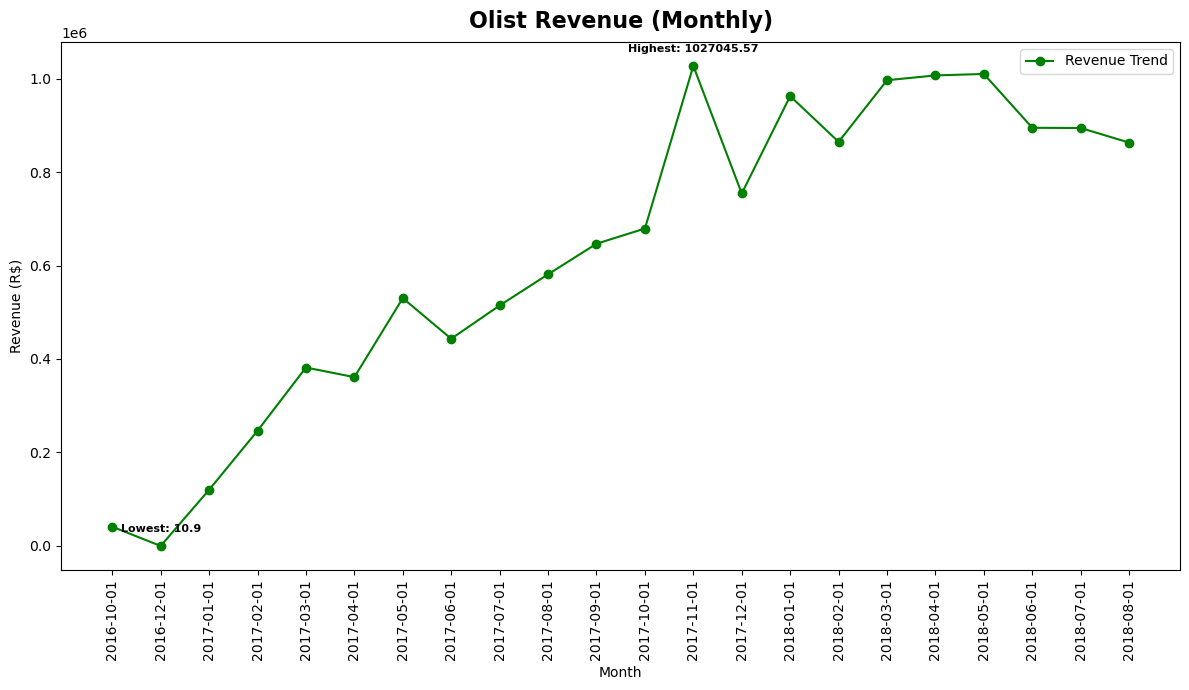

In [756]:
plt.figure(figsize=(12, 7))
monthlyprofit_values = monthly_sales['monthly_revenue'].replace('R$', '').astype(float)
plt.plot(monthly_sales['Year-Month (Purchase)'].astype(str), monthlyprofit_values, marker='o', linestyle='-', color='green',label='Revenue Trend')

# Finding the index of the highest and lowest values
max_index_p = monthlyprofit_values.idxmax()
min_index_p = monthlyprofit_values.idxmin()

# highest and lowest values
plt.annotate(f"Highest: {monthly_sales['monthly_revenue'][max_index_p]}", 
             (monthly_sales['Year-Month (Purchase)'].astype(str)[max_index_p], monthlyprofit_values[max_index_p]),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, fontweight='bold')
plt.annotate(f"Lowest: {monthly_sales['monthly_revenue'][min_index_p]}", 
             (monthly_sales['Year-Month (Purchase)'].astype(str)[min_index_p], monthlyprofit_values[min_index_p]),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, fontweight='bold')

plt.xlabel('Month')
plt.ylabel('Revenue (R$)')
plt.title('Olist Revenue (Monthly)', size=16, pad=10, fontweight='bold')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

plt.show()

In [757]:
print('Multilines Chart of Monthly Sales:')

#Plotly figure with multilines chart
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_orders'],
    mode='lines+markers',
    name='Total Orders'
))

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_buyers'],
    mode='lines+markers',
    name='Total Buyers'
))

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_sellers'],
    mode='lines+markers',
    name='Total Sellers'
))

fig.update_layout(
    title='Total Orders, Buyers, and Sellers (Monthly)', title_x=0.5,
    xaxis_title='Month',
    yaxis_title='Count',
    legend_title='Metric',
    template='plotly_white'
)

Multilines Chart of Monthly Sales:


## Sellers

In [758]:
# Number of unique seller cities:
state_counts = master_olist_dataset['seller_state'].value_counts().reset_index()
state_counts.columns = ['seller_state', 'count']

fig = px.bar(state_counts, x='seller_state', y='count', 
             title='Number of Sellers by State', 
             labels={'count': 'Number of Sellers'})
fig.show()

In [759]:
# Top 10 cities by number of sellers, coloured by state:
city_state = master_olist_dataset.groupby(['seller_city', 'seller_state'])['seller_id'].nunique().reset_index()
city_state.columns = ['seller_city', 'seller_state', 'seller_count']

top_city_state = city_state.sort_values('seller_count', ascending=False).head(10)

fig = px.bar(top_city_state, x='seller_count', y='seller_city', color='seller_state',
             title='Top 10 Cities by Number of Sellers (Coloured by State)',
             labels={'seller_count': 'Number of Sellers', 'seller_city': 'City'})
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [760]:
# Total number of items per seller
seller_kpi = master_olist_dataset.groupby('seller_id').agg(
    total_items=('order_id', 'count'),
    unique_orders=('order_id', 'nunique')
).reset_index()

seller_kpi.head()

seller_id              total_items  unique_orders
0  0015a82c2db000af6aaaf3ae2ecb0532        3             3     
1  001cca7ae9ae17fb1caed9dfb1094831      236           195     
2  002100f778ceb8431b7a1020ff7ab48f       57            50     
3  003554e2dce176b5555353e4f3555ac8        1             1     
4  004c9cd9d87a3c30c522c48c4fc07416      202           156

In [761]:
# Count how many unique sellers each order has
items_per_order = master_olist_dataset.groupby('order_id')['seller_id'].nunique().reset_index(name='unique_seller_count')
items_per_order.head()

order_id              unique_seller_count
0  00010242fe8c5a6d1ba2dd792cb16214           1         
1  00018f77f2f0320c557190d7a144bdd3           1         
2  000229ec398224ef6ca0657da4fc703e           1         
3  00024acbcdf0a6daa1e931b038114c75           1         
4  00042b26cf59d7ce69dfabb4e55b4fd9           1

In [762]:
multiple_sellers_orders = items_per_order[items_per_order['unique_seller_count'] > 1]
multiple_sellers_orders = multiple_sellers_orders.sort_values(by='unique_seller_count', ascending=False)
multiple_sellers_orders

order_id              unique_seller_count
10578  1c11d0f4353b31ac3417fbfa5f0f2a8a           5         
10962  1d23106803c48c391366ff224513fb7f           4         
52498  8c2b13adf3f377c8f2b06b04321b0925           4         
96165  ffb8f7de8940249a3221252818937ecb           3         
63533  a98012aa8c697f2bcff9f8c2183e0f2b           3         
...                                 ...                  ...
33438  591083bc42b589c7052118aa83118e76           2         
33382  58e03095584d960583933517a2aae5df           2         
33345  58c4df4904044782bb1361c5cb001538           2         
32836  57638520434d4c12b81d532ad9bf2f1f           2         
48165  804f733828d8587c734a1d8fc5634e06           2         

[1252 rows x 2 columns]

In [763]:

print(multiple_sellers_orders.shape)

(1252, 2)


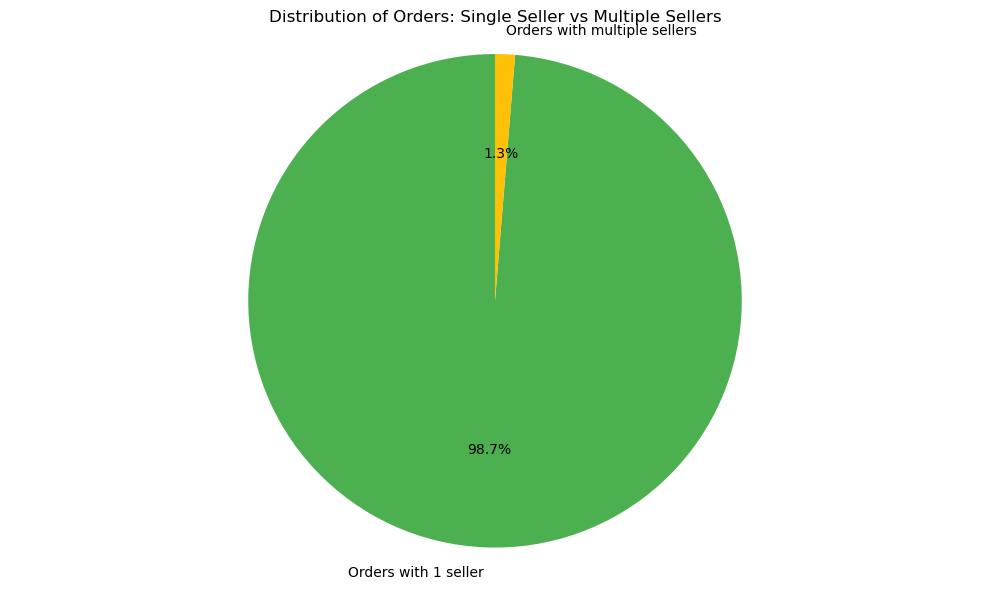

Orders with 1 seller: 95014 (98.70%)
Orders with multiple sellers: 1252 (1.30%)


In [764]:
# Count the number of orders with 1 seller and orders with multiple sellers
single_seller_orders_count = len(items_per_order[items_per_order['unique_seller_count'] == 1])
multiple_seller_orders_count = len(items_per_order[items_per_order['unique_seller_count'] > 1])

# Create labels and values for the pie chart
labels = ['Orders with 1 seller', 'Orders with multiple sellers']
sizes = [single_seller_orders_count, multiple_seller_orders_count]

# Create the pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FFC107'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Orders: Single Seller vs Multiple Sellers')
plt.tight_layout()
plt.show()

# Print the actual numbers
print(f"Orders with 1 seller: {single_seller_orders_count} ({single_seller_orders_count/len(items_per_order)*100:.2f}%)")
print(f"Orders with multiple sellers: {multiple_seller_orders_count} ({multiple_seller_orders_count/len(items_per_order)*100:.2f}%)")

## Customers

In [765]:
df_customers_geo = master_olist_dataset[['customer_id','customer_unique_id','customer_zip_code_prefix','customer_state','customer_city']].reset_index()


In [766]:
df_customers_state = master_olist_dataset[['customer_unique_id', 'customer_state']].drop_duplicates().reset_index(drop=True)


In [767]:
top_state = df_customers_state['customer_state'].value_counts().nlargest(10).reset_index()
top_state

customer_state  count
0       SP        39080
1       RJ        11898
2       MG        10974
3       RS         5149
4       PR         4756
5       SC         3437
6       BA         3154
7       DF         2015
8       ES         1922
9       GO         1889

In [768]:
# Customer state distribution:
fig = px.histogram(
    df_customers_state,
    x='customer_state',
    title='Number of Customers by State',
    labels={'customer_state': 'State'},
    color='customer_state',                     
    color_discrete_sequence=px.colors.qualitative.Plotly,
      
)

fig.update_layout(
    xaxis_title='State',
    yaxis_title='Number of Customers',
    template='plotly_white'
)   
fig.show()


In [769]:
top_cities = df_customers_geo['customer_city'].value_counts().nlargest(20).reset_index()
top_cities

customer_city       count
0               sao paulo  18205
1          rio de janeiro   7958
2          belo horizonte   3186
3                brasilia   2414
4                curitiba   1783
5                campinas   1711
6            porto alegre   1610
7                salvador   1473
8               guarulhos   1361
9   sao bernardo do campo   1096
10                niteroi   1031
11            santo andre    896
12                 osasco    867
13                 santos    836
14                goiania    830
15    sao jose dos campos    799
16              fortaleza    727
17               sorocaba    714
18                 recife    684
19                jundiai    671

In [770]:
# Customer city distribution (top 20):
top_cities = df_customers_geo['customer_city'].value_counts().nlargest(20).reset_index()
top_cities.columns = ['city', 'count']

fig = px.bar(
    top_cities,
    x='city',
    y='count',
    title='Top 20 Customers Cities',
    color='count',
    color_continuous_scale='Oxy'
)

fig.update_layout(
    xaxis_title='Cities',
    yaxis_title='Count',
    template='plotly_white'
)  
fig.show()

##### Customer behaviours 

In [771]:
#popular products by sales count
popular_products = master_olist_dataset.groupby(['product_id','product_category_name','product_category_name_english']).agg(sales_count=('order_id', 'count'), revenue = ('price','sum')).reset_index()
top10_products_bysales = popular_products.sort_values(by='sales_count', ascending=False).head(10)      
display(top10_products_bysales)

product_id             product_category_name  product_category_name_english  sales_count   revenue
21571  aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao            furniture_decor         529      37743.60
19249  99a4788cb24856965c36a24e339b6058         cama_mesa_banho             bed_bath_table         515      45419.96
8409   422879e10f46682990de24d770e7f83d      ferramentas_jardim               garden_tools         508      27851.62
7188   389d119b48cf3043d311335e499d9c6b      ferramentas_jardim               garden_tools         403      22027.49
6908   368c6c730842d78016ad823897a372db      ferramentas_jardim               garden_tools         398      21601.10
10565  53759a2ecddad2bb87a079a1f1519f73      ferramentas_jardim               garden_tools         391      21390.70
26377  d1c427060a0f73f6b889a5c7c61f2ac4  informatica_acessorios      computers_accessories         345      47437.46
10592  53b36df67ebb7c41585e8d54d6772e08      relogios_presentes              watches_gifts         325      37929.42
2725   154e7e31ebfa092203795c972e5804a6            beleza_saude              health_beauty         280       6309.20
7862   3dd2a17168ec895c781a9191c1e95ad7  informatica_acessorios      computers_accessories         276      41382.40

In [772]:
#popular products by revenue
popular_products = master_olist_dataset.groupby(['product_id','product_category_name','product_category_name_english']).agg(sales_count=('order_id', 'count'), revenue = ('price','sum')).reset_index()
top10_products_byrevenue = popular_products.sort_values(by='revenue', ascending=False).head(10)      
display(top10_products_byrevenue)

product_id             product_category_name  product_category_name_english  sales_count   revenue
23496  bb50f2e236e5eea0100680137654686c            beleza_saude              health_beauty         208      68160.00
13718  6cdd53843498f92890544667809f1595            beleza_saude              health_beauty         156      54702.00
26938  d6160fb7873f184099d9bc95e30376af                     pcs                  computers          39      53998.84
26377  d1c427060a0f73f6b889a5c7c61f2ac4  informatica_acessorios      computers_accessories         345      47437.46
19249  99a4788cb24856965c36a24e339b6058         cama_mesa_banho             bed_bath_table         515      45419.96
4879   25c38557cf793876c5abdd5931f922db                   bebes                       baby          44      44829.32
7862   3dd2a17168ec895c781a9191c1e95ad7  informatica_acessorios      computers_accessories         276      41382.40
10592  53b36df67ebb7c41585e8d54d6772e08      relogios_presentes              watches_gifts         325      37929.42
21571  aca2eb7d00ea1a7b8ebd4e68314663af        moveis_decoracao            furniture_decor         529      37743.60
12047  5f504b3a1c75b73d6151be81eb05bdc9              cool_stuff                 cool_stuff          63      37733.90

In [773]:
#type of payment

df_payment_type = master_olist_dataset.groupby('payment_type')['order_id'].count().reset_index()

total_reviews = df_payment_type['order_id'].sum()
df_payment_type['percentage (%)'] = (df_payment_type['order_id'] / total_reviews * 100).round(2)

display(df_payment_type)

payment_type  order_id  percentage (%)
0       boleto    22398        19.46    
1  credit_card    84901        73.77    
2   debit_card     1652         1.44    
3      voucher     6142         5.34

In [774]:
figsegment = go.Figure(data=[go.Pie(
    labels=df_payment_type['payment_type'],  
    values=df_payment_type['percentage (%)'].values,  
    hole=0.4,
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

figsegment.update_traces(textposition='auto')
figsegment.update_layout(
    title_text="Segment Proportion (%)", title_x=0.5,
    showlegend=False
)

figsegment.show()

In [775]:
#repeat customers

orders_per_customer = master_olist_dataset.groupby('customer_unique_id')['order_id'].nunique()
n_repeat_customers = (orders_per_customer > 1).sum()


n_customers = master_olist_dataset['customer_unique_id'].nunique()

repeat_pcg = n_repeat_customers / n_customers
onetime_pcg = 1 - repeat_pcg

display(f'Total Customers: {n_customers}')
display(f'Total Repeat Customers: {n_repeat_customers}')
display(f'Total One-time Customers: {n_customers - n_repeat_customers}')
display(f'Repeat Customers Percentage / Customer retention: {repeat_pcg:.2%}')
display(f'One time Customers Percentage: {onetime_pcg:.2%}')
display(orders_per_customer.describe())

'Total Customers: 93155'

'Total Repeat Customers: 2793'

'Total One-time Customers: 90362'

'Repeat Customers Percentage / Customer retention: 3.00%'

'One time Customers Percentage: 97.00%'

count    93155.000000
mean         1.033396
std          0.209001
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: order_id, dtype: float64

In [776]:
#basket size 

#basket size based on order_item_id
n_item_per_order = master_olist_dataset.groupby('order_item_id')['order_id'].count().reset_index()
total_reviews = n_item_per_order['order_id'].sum()
n_item_per_order['percentage (%)'] = (n_item_per_order['order_id'] / total_reviews * 100).round(3)

# Display the result
display(n_item_per_order)

order_item_id  order_id  percentage (%)
0        1.0        100810       87.590    
1        2.0         10069        8.749    
2        3.0          2332        2.026    
3        4.0           958        0.832    
4        5.0           450        0.391    
5        6.0           255        0.222    
6        7.0            60        0.052    
7        8.0            37        0.032    
8        9.0            29        0.025    
9       10.0            26        0.023    
10      11.0            18        0.016    
11      12.0            13        0.011    
12      13.0             8        0.007    
13      14.0             7        0.006    
14      15.0             5        0.004    
15      16.0             3        0.003    
16      17.0             3        0.003    
17      18.0             3        0.003    
18      19.0             3        0.003    
19      20.0             3        0.003    
20      21.0             1        0.001

In [777]:

fig = px.histogram(master_olist_dataset, x="order_item_id",
             color='order_item_id', barmode='relative',
             histfunc='count', text_auto=True,
             height=1000, width=700,
             labels={
                     "order_item_id": "Order Item ID",
                     })

fig.update_traces(textposition='outside',texttemplate="<b>%{y:.2f}</b>")
fig.update_layout(
    title_text="Number of item per order", title_x=0.5,
    barmode="relative",
    uniformtext=dict(mode="hide", minsize=10),
    xaxis={'categoryorder': 'total ascending'}
)
fig.show()

As an additional analyses, we want to understand about high and low value customers for customer segmentation. **Here, we use RFM - Recency, Frequency and Monetary scoring to identify the high and low value customer that previously bought product from Olist.**

1. Recency: How recently the customer made a purchase
2. Frequency: how often the customer makes purchases
3. Monetary: how much money (total amount) was spent to buy the products

In [778]:
df_custrecency = master_olist_dataset.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
df_custrecency.columns = ['Customer', 'LastPurchaseDate']
recent_date = df_custrecency['LastPurchaseDate'].max()
df_custrecency['Recency'] = df_custrecency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
df_custrecency = df_custrecency.sort_values(by='Recency', ascending=True).reset_index(drop=True)

display(df_custrecency.head(), df_custrecency.tail())

Customer               LastPurchaseDate   Recency
0  fb7e29c65321441231990afc201c1b14 2018-08-28 19:32:05     0   
1  21dbe8eabd00b34492a939c540e2b1a7 2018-08-29 10:22:35     0   
2  24ac2b4327e25baf39f2119e4228976a 2018-08-29 15:00:37     0   
3  77367b6fbb034ca710d4f41aad009151 2018-08-28 21:10:46     0   
4  c45221bb4573f66bdd4daf43fe2d4b3b 2018-08-28 19:27:43     0

Customer               LastPurchaseDate   Recency
93150  87776adb449c551e74c13fc34f036105 2016-10-03 22:31:31    694  
93151  61db744d2f835035a5625b59350c6b63 2016-10-03 21:13:36    694  
93152  88bc832f104b6dd684a17dbb1b76e778 2016-10-04 09:59:03    694  
93153  10e89fd8e5c745f81bec101207ba4d7d 2016-10-03 22:51:30    694  
93154  5f7e36fb1d42d0b1c408b5b41bc52bb3 2016-10-04 13:15:52    694

In [779]:
custfrequency_df = (
    master_olist_dataset[['customer_unique_id', 'order_id']]
    .drop_duplicates()
    .groupby('customer_unique_id', as_index=False)
    .count()
    .rename(columns={'order_id': 'Frequency', 'customer_unique_id': 'Customer'})
    .sort_values(by='Frequency', ascending=False)
    .reset_index(drop=True) 
)

display(custfrequency_df.head(), custfrequency_df.tail())

Customer              Frequency
0  8d50f5eadf50201ccdcedfb9e2ac8455     15    
1  3e43e6105506432c953e165fb2acf44c      9    
2  1b6c7548a2a1f9037c1fd3ddfed95f33      7    
3  6469f99c1f9dfae7733b25662e7f1782      7    
4  ca77025e7201e3b30c44b472ff346268      7

Customer              Frequency
93150  56636fd22de1a315b8a50d45cf94d859      1    
93151  5663350f41f9077e7c27f2ab1131bd13      1    
93152  5662855e2f6ad60ab412adcd3ed030fe      1    
93153  566247c9538d4a0c5739d6f11f73c655      1    
93154  ffffd2657e2aad2907e67c3e9daecbeb      1

In [780]:
monetary_df = master_olist_dataset.groupby(by='customer_unique_id', as_index=False)['price'].sum().sort_values(by='price', ascending=False)
monetary_df.columns = ['Customer', 'Monetary']
display(monetary_df.head(), monetary_df.tail())

Customer              Monetary
3713   0a0a92112bd4c708ca5fde585afaa872  13440.00
71654  c4b224d2c784bae11ae98b6ae9f2454c  10856.10
48613  85963fd37bfd387aa6d915d8a1065486   9888.00
69394  be74c431147c32ab2d7c7cef5e4a995f   9520.14
86699  edf81e1f3070b9dac83ec83dacdbb9bc   7998.00

Customer              Monetary
39888  6d6065917074c293416673faaba09336    3.00  
75448  cf3839da0d9492ad151690b65f45d800    2.99  
68867  bd06ce0e06ad77a7f681f1a4960a3cc6    2.29  
65398  b38211bd797f4fdd81a98b9d1754b606    0.85  
78718  d80730c15c647bc8f2ad77c908ba5ca9    0.85

In [781]:
rf_df = df_custrecency.merge(custfrequency_df, on='Customer')
rfm_df = rf_df.merge(monetary_df, on='Customer').drop(
    columns='LastPurchaseDate')

rfm_df.head(10)

Customer              Recency  Frequency  Monetary
0  fb7e29c65321441231990afc201c1b14     0         2       268.69 
1  21dbe8eabd00b34492a939c540e2b1a7     0         1         6.90 
2  24ac2b4327e25baf39f2119e4228976a     0         1        84.99 
3  77367b6fbb034ca710d4f41aad009151     0         1        59.90 
4  c45221bb4573f66bdd4daf43fe2d4b3b     0         1        29.90 
5  5c58de6fb80e93396e2f35642666b693     0         1       418.00 
6  a712a430955027da5bc257a10073a390     0         1       149.90 
7  83176537f63ef9c7510572006c85ac50     0         1       712.90 
8  36a5c01d940c382346247b3e6c485c2d     0         1        29.99 
9  44d111bdc55faca551ef91cb74a444d8     0         1       249.90

In [782]:
rf_df_2 = custfrequency_df.merge(monetary_df, on='Customer')
rf_df_2.head(10)

Customer              Frequency  Monetary
0  8d50f5eadf50201ccdcedfb9e2ac8455     15        714.63
1  3e43e6105506432c953e165fb2acf44c      9       1000.85
2  1b6c7548a2a1f9037c1fd3ddfed95f33      7        855.21
3  6469f99c1f9dfae7733b25662e7f1782      7        664.20
4  ca77025e7201e3b30c44b472ff346268      7        806.61
5  12f5d6e1cbf93dafd9dcc19095df0b3d      6         58.40
6  63cfc61cee11cbe306bff5857d00bfe4      6        579.81
7  dc813062e0fc23409cd255f7f53c7074      6        687.76
8  47c1a3033b8b77b3ab6e109eb4d5fdf3      6        874.60
9  f0e310a6839dce9de1638e0fe5ab282a      6        438.09

## Review

In [783]:
df_reviews = master_olist_dataset.copy()  # Replace with your full review dataset

In [784]:

fig = px.histogram(df_reviews, x="review_score",
             color='review_score', barmode='relative',
             histfunc='count', text_auto=True,
             height=700, width=700,
             labels={
                     "review_score": "Review Score",
                     },
             category_orders={'Review Score': [1, 2, 3, 4, 5]}
            )

fig.update_traces(textposition='outside',texttemplate="<b>%{y:.1f}</b>")

fig.update_layout(
    title_text="Rating", title_x=0.5,
    barmode="relative",
    uniformtext=dict(mode="hide", minsize=10),
    xaxis={'categoryorder': 'total ascending'}
)
fig.show()

In [785]:
# Make sure comment length and month are already computed:
df_reviews['comment_length'] = df_reviews['review_comment_message'].astype(str).apply(len)
df_reviews['month'] = pd.to_datetime(df_reviews['review_creation_date']).dt.to_period("M").astype(str)

# Count reviews per score per month:
low_score_summary = (
    df_reviews[df_reviews['review_score'].isin([1, 2, 3])]
    .groupby(['month', 'review_score'])
    .agg(count=('review_id', 'count'))
    .reset_index()
)

# Pivot to wide format:
highlight_table = low_score_summary.pivot(index='month', columns='review_score', values='count').fillna(0)

# Add a total low score column:
highlight_table['total_low_reviews'] = highlight_table.sum(axis=1)

# Sort by total_low_reviews:
highlight_table = highlight_table.sort_values(by='total_low_reviews', ascending=False)

In [786]:
# all review scores (1 to 5)
all_score_summary = df_reviews.copy() 
all_score_summary['review_score'] = all_score_summary['review_score'].astype(str)

# Group by month and review_score
all_score_plot_data = (
    all_score_summary
    .groupby(['month', 'review_score'])
    .size()
    .reset_index(name='count')
)

# Plot
fig = px.bar(
    all_score_plot_data,
    x='month',
    y='count',
    color='review_score',
    barmode='stack',
    title='Review Score Distribution by Month (1–5 Stars)',
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Number of Reviews'
)

fig.show()

In [787]:
# Display the top 10 months with the most low score reviews:
top_low_score_months = highlight_table.head(10)
top_low_score_months

review_score    1.0    2.0    3.0   total_low_reviews
month                                                
2018-03       1825.0  366.0  861.0       3052.0      
2017-12       1394.0  372.0  787.0       2553.0      
2018-04       1280.0  353.0  730.0       2363.0      
2018-08        873.0  301.0  719.0       1893.0      
2018-02        888.0  249.0  669.0       1806.0      
2018-01        869.0  272.0  633.0       1774.0      
2018-05        861.0  246.0  649.0       1756.0      
2018-06        814.0  268.0  654.0       1736.0      
2017-11        572.0  173.0  529.0       1274.0      
2018-07        518.0  160.0  462.0       1140.0

In [788]:
# Review monthly (1-3 stars) ::
highlight_plot_data = low_score_summary.copy()
highlight_plot_data['review_score'] = highlight_plot_data['review_score'].astype(str)

fig = px.bar(
    highlight_plot_data,
    x='month',
    y='count',
    color='review_score',
    barmode='stack',
    title='Low Review Score Distribution by Month (1-3 Stars)',
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Reviews')
fig.show()

## Delivery

#### General delivery performance

In [789]:
# Core delay & flag features
master_olist_dataset['is_late']    = master_olist_dataset['order_delivered_customer_date'] > master_olist_dataset['order_estimated_delivery_date']
master_olist_dataset['late_days']    = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_estimated_delivery_date']).dt.days
master_olist_dataset['dispatch_delay'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['shipping_limit_date']).dt.days
master_olist_dataset['is_late_dispatch'] = (master_olist_dataset['dispatch_delay'] > 0)
master_olist_dataset['dispatch_time'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['order_approved_at']).dt.days
master_olist_dataset['transit_time']  = (master_olist_dataset['order_delivered_customer_date']  - master_olist_dataset['order_delivered_carrier_date']).dt.days
master_olist_dataset['delivery_days'] = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_purchase_timestamp']).dt.days

# Review bucket
master_olist_dataset['review_bucket'] = master_olist_dataset['review_score'].apply(lambda x: 'Good (4-5)' if x > 3 else 'Bad (1-3)')

In [790]:
master_olist_dataset.head()

order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix customer_city customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name   product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix   seller_city   seller_state  payment_sequential payment_type  payment_installments  payment_value             review_id              review_score review_comment_title                                                                            review_comment_message                                                                           review_creation_date  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               1.0         credit_card           1.0              18.12      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               3.0             voucher           1.0               2.00      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   delivered    2017-10-02 10:56:33    2017-10-02 11:07:15     2017-10-04 19:55:00           2017-10-10 21:25:13                2017-10-18           7c396fd4830fd04220f754e42b4e5bff             3149             sao paulo        SP             1.0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15   29.99       8.72      utilidades_domesticas         40.0                     268.0                    4.0               500.0             19.0                8.0               13.0                 9350.0                   maua      SP               2.0             voucher           1.0              18.59      a54f0611adc9ed256b57ede6b6eb5114       4.0                    NaN    Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.      2017-10-11        
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef  

In [791]:
#define functions for late
late_delivery = master_olist_dataset[master_olist_dataset['is_late'] == True].count()['order_id']
total_orders = master_olist_dataset.count()['order_id']
late_delivery_rate = (late_delivery / total_orders) * 100
ontime_delivery_rate = 100 - late_delivery_rate

# Create a pie chart
fig_pie_pull = go.Figure(data=[go.Pie(
    labels = ['On-Time Delivery', 'Late Delivery'],
    values = [ontime_delivery_rate, late_delivery_rate],
    pull = [0, 0.3],
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

fig_pie_pull.update_traces(textposition='auto')
fig_pie_pull.update_layout(
    title_text=" Delivery Performance (%)", title_x=0.5,
    showlegend=True
)
fig_pie_pull.show()

#print
print(f"Late Deliveries: {late_delivery}")
print(f"Total Orders: {total_orders}")
print(f"Late Delivery Rate: {late_delivery_rate:.2f}%")
print(f"On-time Delivery Rate: {ontime_delivery_rate:.2f}%")

Late Deliveries: 9041
Total Orders: 115093
Late Delivery Rate: 7.86%
On-time Delivery Rate: 92.14%


#this below can be deleted (but later)

In [792]:
# detail analysis in late and ontime delivery based on dispatch and delivery rate 

df_delivery_segmentation = master_olist_dataset.copy()
def delivery_seg(row):
    if row['is_late_dispatch'] and row['is_late']:
        return 'Late Dispatch and Late Delivery'
    elif not row['is_late_dispatch'] and row['is_late']:
        return 'On-Time Dispatch and Late Delivery'
    elif row['is_late_dispatch'] and not row['is_late']:
        return 'Late Dispatch and On-Time Delivery'
    else:
        return 'On-Time Dispatch and On-Time Delivery'


# add column
df_delivery_segmentation['delivery_segmentation'] = df_delivery_segmentation.apply(delivery_seg, axis=1)

# Count and percentage
del_seg_counts = df_delivery_segmentation['delivery_segmentation'].value_counts()
del_seg_percent = (del_seg_counts / del_seg_counts.sum() * 100).round(2)

display(del_seg_counts, del_seg_percent)

delivery_segmentation
On-Time Dispatch and On-Time Delivery    102534
On-Time Dispatch and Late Delivery         7224
Late Dispatch and On-Time Delivery         3518
Late Dispatch and Late Delivery            1817
Name: count, dtype: int64

delivery_segmentation
On-Time Dispatch and On-Time Delivery    89.09
On-Time Dispatch and Late Delivery        6.28
Late Dispatch and On-Time Delivery        3.06
Late Dispatch and Late Delivery           1.58
Name: count, dtype: float64

In [793]:
# Create a pie chart
pull_map = {
    'Late Dispatch and Late Delivery': 0.5,
    'Late Dispatch and On-Time Delivery': 0.1,
    'On-Time Dispatch and Late Delivery': 0.3,
    'On-Time Dispatch and On-Time Delivery': 0
}


fig_pie_pull_seg = go.Figure(data=[go.Pie(
    labels = del_seg_percent.index,
    values = del_seg_percent.values,
    pull = [pull_map.get(seg, 0) for seg in del_seg_percent.index],
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

fig_pie_pull_seg.update_traces(textposition='outside')
fig_pie_pull_seg.update_layout(
    title_text=" Delivery Performance Segmentation (%)", title_x=0.5,
    showlegend=True
)
fig_pie_pull_seg.show()

#delineation only at the late part 

In [794]:
# detail analysis in late and ontime delivery based on dispatch and delivery rate 

df_delivery_segmentation = master_olist_dataset.copy()
def delivery_seg(row):
    if row['is_late_dispatch'] and row['is_late']:
        return 'Late Dispatch and Late Delivery'
    elif not row['is_late_dispatch'] and row['is_late']:
        return 'On-Time Dispatch and Late Delivery'
    else:
        return 'On-Time Delivery'


# add column
df_delivery_segmentation['delivery_segmentation'] = df_delivery_segmentation.apply(delivery_seg, axis=1)

# Count and percentage
del_seg_counts = df_delivery_segmentation['delivery_segmentation'].value_counts()
del_seg_percent = (del_seg_counts / del_seg_counts.sum() * 100).round(2)

display(del_seg_counts, del_seg_percent)

delivery_segmentation
On-Time Delivery                      106052
On-Time Dispatch and Late Delivery      7224
Late Dispatch and Late Delivery         1817
Name: count, dtype: int64

delivery_segmentation
On-Time Delivery                      92.14
On-Time Dispatch and Late Delivery     6.28
Late Dispatch and Late Delivery        1.58
Name: count, dtype: float64

In [795]:
# Create a pie chart
pull_map = {
    'On-Time Delivery': 0,
    'Late Dispatch and Late Delivery': 0.2,
    'On-Time Dispatch and Late Delivery': 0.4
}


fig_pie_pull_seg = go.Figure(data=[go.Pie(
    labels = del_seg_percent.index,
    values = del_seg_percent.values,
    pull = [pull_map.get(seg, 0) for seg in del_seg_percent.index],
    hoverinfo='label+percent+value',
    textinfo='percent+label'
)])

fig_pie_pull_seg.update_traces(textposition='outside')
fig_pie_pull_seg.update_layout(
    title_text=" Delivery Performance Segmentation (%)", title_x=0.5,
    showlegend=True
)
fig_pie_pull_seg.show()

#### Relationship between delivery days and reviews

In [796]:
df_deli_review = master_olist_dataset.groupby('review_score')['delivery_days'].median().reset_index()
df_deli_review

review_score  delivery_days
0       1.0          14.0     
1       2.0          12.0     
2       3.0          11.0     
3       4.0          10.0     
4       5.0           9.0

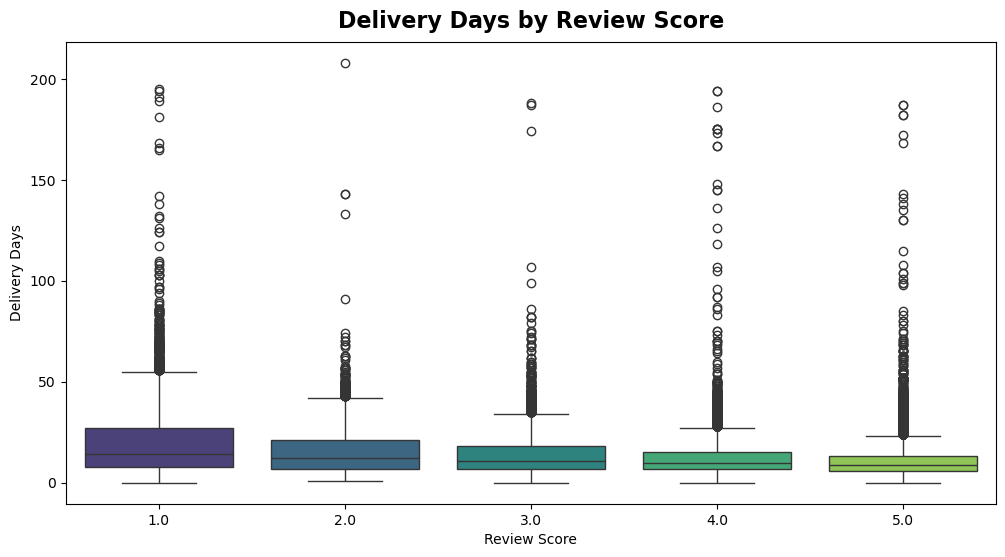

In [797]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df_delivery_segmentation['review_score'], y=df_delivery_segmentation['delivery_days'], palette='viridis')
plt.xlabel('Review Score')
plt.ylabel('Delivery Days')
plt.title('Delivery Days by Review Score', size=16, pad=10, fontweight='bold')
plt.show()

review_score   is_late  late_days  dispatch_delay  dispatch_time  transit_time  delivery_days
review_score      1.000000   -0.274697 -0.152546     -0.067458      -0.104365      -0.178560     -0.220983   
is_late          -0.274697    1.000000  0.466419      0.153993       0.136034       0.340957      0.391011   
late_days        -0.152546    0.466419  1.000000      0.306719       0.174841       0.228807      0.310725   
dispatch_delay   -0.067458    0.153993  0.306719      1.000000       0.590841      -0.042452      0.181418   
dispatch_time    -0.104365    0.136034  0.174841      0.590841       1.000000       0.038517      0.387714   
transit_time     -0.178560    0.340957  0.228807     -0.042452       0.038517       1.000000      0.880884   
delivery_days    -0.220983    0.391011  0.310725      0.181418       0.387714       0.880884      1.000000

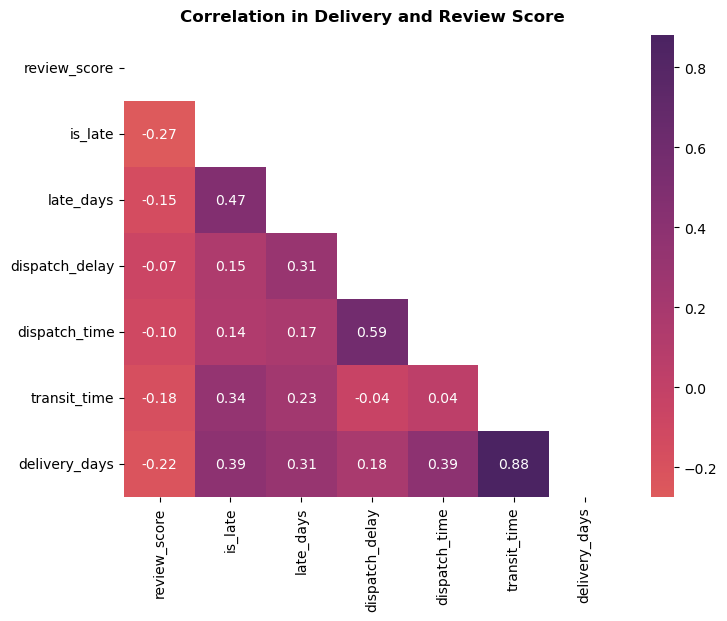

In [798]:
#correlation between numerical variables
correlation_delivery = master_olist_dataset[['review_score','is_late','late_days','dispatch_delay','dispatch_time','transit_time','delivery_days']].corr(method = "spearman")
mtrx = np.triu(correlation_delivery)
display(correlation_delivery)

plt.figure(figsize = (8, 6))
sns.heatmap(
    data = correlation_delivery,
    annot = True,
    fmt = ".2f",
    cmap = "flare",
    center = 0,
    mask = mtrx
)

plt.title("Correlation in Delivery and Review Score", size=12, pad=10, fontweight='bold')
plt.show()

In [799]:
#review bucket 
master_olist_dataset['review_bucket'] = master_olist_dataset['review_score'].apply(lambda x: 'Good (4-5)' if x > 3 else 'Bad (1-3)')

# Create contingency table
cont_table = pd.crosstab(master_olist_dataset['is_late'], master_olist_dataset['review_bucket'])

# chi-square test
chi_square, p_value, dof, expected = chi2_contingency(cont_table)

# print
print("Chi-square statistic:", chi_square)
print("p-value:", p_value)

# Interpret
if p_value < 0.05:
    print("✅ Statistically significant: Late delivery affects review score.")
else:
    print("❌ Not significant: No strong evidence that late delivery affects review score.")

Chi-square statistic: 9783.668378106478
p-value: 0.0
✅ Statistically significant: Late delivery affects review score.


#### How late delivery affecting customer retention - for first timer order

In [800]:
# Customer repeat & first-order flags
master_olist_dataset = master_olist_dataset.sort_values(['customer_unique_id','order_purchase_timestamp'])
master_olist_dataset['order_rank']        = master_olist_dataset.groupby('customer_unique_id')['order_purchase_timestamp'] \
                              .rank(method='first')
master_olist_dataset['first_order_flag']  = master_olist_dataset['order_rank'] == 1

order_counts = master_olist_dataset.groupby('customer_unique_id')['order_id'].nunique()
master_olist_dataset['customer_repeat_flag'] = master_olist_dataset['customer_unique_id'].map(order_counts > 1)

master_olist_dataset.head()

order_id                        customer_id            order_status order_purchase_timestamp  order_approved_at  order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date         customer_unique_id         customer_zip_code_prefix customer_city customer_state  order_item_id             product_id                        seller_id             shipping_limit_date   price  freight_value product_category_name  product_name_lenght  product_description_lenght  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  product_width_cm  seller_zip_code_prefix      seller_city      seller_state  payment_sequential payment_type  payment_installments  payment_value             review_id              review_score review_comment_title                                              review_comment_message                                              review_creation_date review_answer_timestamp  has_review  \
61019   e22acc9c116caa3f2b7121bbb380d08e  fadbb3709178fc513abc1b2670aa1ad2   delivered    2018-05-10 10:56:27    2018-05-10 11:11:18     2018-05-12 08:18:00           2018-05-16 20:48:37                2018-05-21           0000366f3b9a7992bf8c76cfdf3221e2             7787              cajamar         SP             1.0       372645c7439f9661fbbacfd129aa92ec  da8622b14eb17ae2831f4ac5b9dab84a 2018-05-15 11:11:18  129.90      12.00         cama_mesa_banho           60.0                     236.0                    1.0              1500.0             34.0                7.0               32.0                13405.0                   piracicaba      SP               1.0         credit_card           8.0             141.90      13359f48c3c7e41a2b8afca340937eeb       5.0        Super Recomendo    Adorei a cortina, ficou linda na minha sala, e o tecido é lindo deixa a sala muito sofisticada. super recomendo      2018-05-17        2018-05-21 13:44:48       True      
85359   3594e05a005ac4d06a72673270ef9ec9  4cb282e167ae9234755102258dd52ee8   delivered    2018-05-07 11:11:27    2018-05-07 18:25:44     2018-05-09 12:18:00           2018-05-10 18:02:42                2018-05-15           0000b849f77a49e4a4ce2b2a4ca5be3f             6053               osasco         SP             1.0       5099f7000472b634fea8304448d20825  138dbe45fc62f1e244378131a6801526 2018-05-11 17:56:33   18.90       8.29            beleza_saude           56.0                     635.0                    1.0               375.0             26.0               11.0               18.0                 2215.0                    sao paulo      SP               1.0         credit_card           1.0              27.19      e383e10e36a765f04f752a37c1674e43       4.0                    NaN                                                                                                                NaN      2018-05-11        2018-05-11 22:29:25       True      
30624   b33ec3b699337181488304f362a6b734  9b3932a6253894a02c1df9d19004239f   delivered    2017-03-10 21:05:03    2017-03-10 21:05:03     2017-03-13 12:58:30           2017-04-05 14:38:47                2017-04-07           0000f46a3911fa3c0805444483337064            88115             sao jose         SC             1.0       64b488de448a5324c4134ea39c28a34b  3d871de0142ce09b7081e2b9d1733cb1 2017-03-15 21:05:03   69.00      17.22               papelaria           49.0                     177.0                    3.0              1500.0             25.0               50.0               35.0                13232.0         campo limpo paulista      SP               1.0         credit_card           8.0              86.22      d89cb4217c23008b141e66c3160de8a4       3.0                    NaN                                                                                                                NaN      2017-04-06        2017-04-07 01:19:44       True      
113968  41272756ecddd9a9ed0180413cc22fb6  914991f0c02ef0843c0e7010c819d642   delivered    2017-10-12 20:29:41    2017-10-12 20:4

In [801]:
# Retention delta (Δ repeat-rate between on-time vs. late first orders)
firsts = master_olist_dataset[master_olist_dataset['first_order_flag']]
ret = firsts.groupby('is_late').agg(
    total_customers=('customer_unique_id','nunique'),
    repeat_customers=('customer_repeat_flag', 'sum')
).reset_index()
ret['repeat_rate'] = ret['repeat_customers']/ret['total_customers']

rr_on_time = ret.loc[ret['is_late']==False, 'repeat_rate'].iloc[0]
rr_late    = ret.loc[ret['is_late']==True,  'repeat_rate'].iloc[0]
retention_delta = rr_on_time - rr_late

print(f"Retention on time first orders: {rr_on_time*100:.4f}%")
print(f"Retention late first orders: {rr_late*100:.4f}%")
print(f"Retention Δ (on-time vs late first orders): {retention_delta*100:.4f}%")

Retention on time first orders: 3.0413%
Retention late first orders: 2.5132%
Retention Δ (on-time vs late first orders): 0.5282%


In [802]:
#Impact model: lost revenue from late first orders
late_first_count = ret.loc[ret['is_late']==True, 'total_customers'].iloc[0]
avg_order_value  = master_olist_dataset['payment_value'].mean()
lost_revenue     = retention_delta * late_first_count * avg_order_value

print(f"Estimated lost revenue from late first orders: {lost_revenue:,.2f}")

Estimated lost revenue from late first orders: 6,901.66


In [803]:
#chisuare analysis 
#  contingency table
cont_table = pd.crosstab(
    firsts['is_late'],
    firsts['customer_repeat_flag']
)

# rename rows/cols for readability
cont_table.index = ['On-Time First Order', 'Late First Order']
cont_table.columns = ['Not Repeated', 'Repeated']

# Chi-Square test
chi2, p, dof, expected = chi2_contingency(cont_table)

# Print
print("Contingency Table:\n", cont_table)
print(f"\nChi² Statistic: {chi2:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p:.6f}")

if p < 0.05:
    print("\n✅ Statistically significant: Late delivery is associated with customer retention.")
else:
    print("\n❌ Not statistically significant: No clear evidence that late delivery affects retention.")

Contingency Table:
                      Not Repeated  Repeated
On-Time First Order      82953       2602  
Late First Order          7409        191  

Chi² Statistic: 6.5145
Degrees of Freedom: 1
P-value: 0.010700

✅ Statistically significant: Late delivery is associated with customer retention.


### In-dept analysis of delivery performance 

##### On-time Delivery Rate of Olist e-commerce 

In [804]:
# Monthly OTD rate calculation:
df_delivery_segmentation['delivery_month'] = df_delivery_segmentation['order_delivered_customer_date'].dt.to_period('M')
df_delivery_segmentation['delivered_on_time'] = df_delivery_segmentation['is_late'] == False


monthly_otd = (
    df_delivery_segmentation.groupby('delivery_month').agg(
        total_orders=('order_id', 'count'),
        late_orders=('is_late', 'sum'),
        on_time_orders=('delivered_on_time', 'sum')
    ).reset_index()
)

#Calculate OTD rate
monthly_otd['OTD (%)'] = (monthly_otd['on_time_orders'] / monthly_otd['total_orders']) * 100
monthly_otd['OTD (%)'] = monthly_otd['OTD (%)'].round(2)

# Present and print
monthly_otd = monthly_otd.rename(columns={
    'delivery_month': 'Month',
    'total_orders': 'Total Orders',
    'late_orders': 'Late Orders',
    'on_time_orders': 'On-Time Orders'
})



monthly_otd


Month    Total Orders  Late Orders  On-Time Orders  OTD (%)
0   2016-10       245            0            245       100.00 
1   2016-11        80            1             79        98.75 
2   2016-12         4            2              2        50.00 
3   2017-01       342            0            342       100.00 
4   2017-02      1647            3           1644        99.82 
5   2017-03      2912           71           2841        97.56 
6   2017-04      2177          131           2046        93.98 
7   2017-05      4478          254           4224        94.33 
8   2017-06      3872          138           3734        96.44 
9   2017-07      4158          154           4004        96.30 
10  2017-08      5226          134           5092        97.44 
11  2017-09      4743          202           4541        95.74 
12  2017-10      5519          270           5249        95.11 
13  2017-11      5681          275           5406        95.16 
14  2017-12      8659          898           7761        89.63 
15  2018-01      7734          770           6964        90.04 
16  2018-02      6933          435           6498        93.73 
17  2018-03      8277         1279           6998        84.55 
18  2018-04      9306         1651           7655        82.26 
19  2018-05      8442          522           7920        93.82 
20  2018-06      8196          674           7522        91.78 
21  2018-07      6774          115           6659        98.30 
22  2018-08      9626         1000           8626        89.61 
23  2018-09        59           59              0         0.00 
24  2018-10         3            3              0         0.00

In [805]:
# Filter for deliveries completed before 2018:
df_pre_2018 = df_delivery_segmentation[
    df_delivery_segmentation['order_delivered_customer_date'].dt.year < 2018
].copy()

# Calculate total and on-time deliveries:
total_deliveries_pre_2018 = len(df_pre_2018)
on_time_deliveries_pre_2018 = df_pre_2018['delivered_on_time'].sum()

# Calculate OTD:
otd_pre_2018 = (on_time_deliveries_pre_2018 / total_deliveries_pre_2018) * 100
print(f"OTD Rate for 2016-2017: {otd_pre_2018:.2f}%")

# Also display the count for context
print(f"Total deliveries in 2016-2017: {total_deliveries_pre_2018}")
print(f"On-time deliveries in 2016-2017: {on_time_deliveries_pre_2018}")

OTD Rate for 2016-2017: 94.91%
Total deliveries in 2016-2017: 49743
On-time deliveries in 2016-2017: 47210


In [806]:
# Filter for deliveries completed in 2018:
df_2018 = df_delivery_segmentation[
    df_delivery_segmentation['order_delivered_customer_date'].dt.year == 2018
].copy()

# Calculate total and on-time deliveries:
total_deliveries_2018 = len(df_2018)
on_time_deliveries_2018 = df_2018['delivered_on_time'].sum()

# Calculate OTD:
otd_2018 = (on_time_deliveries_2018 / total_deliveries_2018) * 100
print(f"OTD Rate for 2018: {otd_2018:.2f}%")
print(f"Total deliveries in 2018: {total_deliveries_2018}")
print(f"On-time deliveries in 2018: {on_time_deliveries_2018}")

OTD Rate for 2018: 90.04%
Total deliveries in 2018: 65350
On-time deliveries in 2018: 58842


In [807]:

monthly_otd['Month'] = monthly_otd['Month'].astype(str)

# Filter out months with 0% OTD --> no sales 
monthly_otd_filtered = monthly_otd[~monthly_otd['Month'].isin(['2018-09', '2018-10'])].copy()
monthly_otd_filtered = monthly_otd_filtered.sort_values('Month').reset_index(drop=True)

#Prepare y values
y_vals = monthly_otd_filtered['OTD (%)'].values

# Plotly line chart
fig = go.Figure()

# Main OTD line:
fig.add_trace(go.Scatter(
    x=monthly_otd_filtered['Month'],
    y=y_vals,
    mode='lines+markers',
    name='OTD',
    line=dict(color='blue', width=3),
    marker=dict(color='blue', size=8)
))

# Highlight points below 95%:
below_95 = monthly_otd_filtered[monthly_otd_filtered['OTD (%)'] < 95]

fig.add_trace(go.Scatter(
    x=below_95['Month'],
    y=below_95['OTD (%)'],
    mode='markers+text',
    name='Below 95%',
    marker=dict(color='red', size=10, symbol='circle-open'),
    text=['⚠️' for _ in range(len(below_95))],
    textposition='top center',
    showlegend=True
))

fig.update_layout(
    title='Monthly On-Time Delivery (OTD) Trend (Excl. Sep-Oct 2018)',
    xaxis_title='Month',
    yaxis_title='OTD (%)',
    yaxis_range=[75, 101],
    template='plotly_white'
)

fig.show()

In [808]:
# combining two factors OTD and the total orders per month 
# left y axis is OTD rate
fig.add_trace(go.Scatter(
    x=monthly_otd_filtered['Month'],
    y=monthly_otd_filtered['OTD (%)'],
    mode='lines+markers',
    name='OTD (%)',
    line=dict(color='blue', width=3),
    marker=dict(color='blue', size=8),
    yaxis='y1',
    legendgroup= 'otd',
    showlegend=True
))

# right Y axis is the total month order 
fig.add_trace(go.Scatter(
    x=monthly_otd_filtered['Month'],
    y=monthly_otd_filtered['Total Orders'],
    mode='lines+markers',
    name='Total Orders',
    line=dict(color='orange', width=3, dash='dot'),
    marker=dict(color='orange', size=8),
    yaxis='y2'
))

# Highlight OTD below 95% --> for the left axis 
below_95 = monthly_otd_filtered[monthly_otd_filtered['OTD (%)'] < 95]

fig.add_trace(go.Scatter(
    x=below_95['Month'],
    y=below_95['OTD (%)'],
    mode='markers+text',
    name='OTD <95%',
    marker=dict(color='red', size=10, symbol='circle-open'),
    text=['⚠️' for _ in range(len(below_95))],
    textposition='top center',
    showlegend=False,
    yaxis='y1'
))

# layout for two y axes 
fig.update_layout(
    title='Monthly On-Time Delivery Rate vs. Total Orders',
    xaxis=dict(title='Month'),
    yaxis=dict(
        title='OTD (%)',
        range=[75, 101],
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title='Total Orders',
        overlaying='y',
        side='right',
        titlefont=dict(color='orange'),
        tickfont=dict(color='orange')
    ),
    legend=dict(x=1.05, y=1, bordercolor="gray", borderwidth=1),
    template='plotly_white',
    margin=dict(r=200) 
)

fig.show()

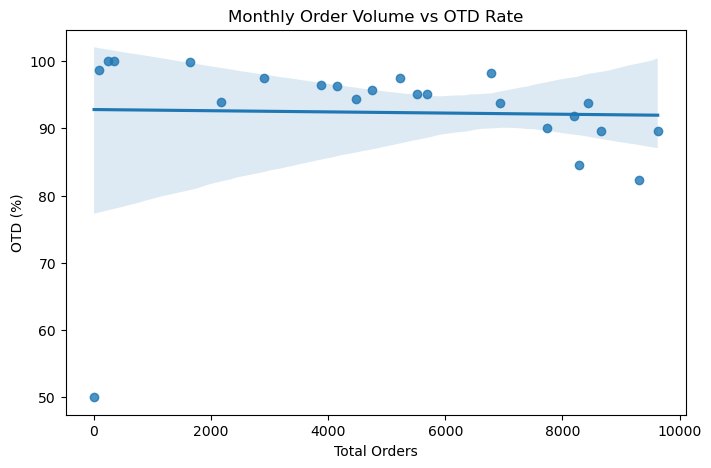

Spearman correlation: -0.627 (p=0.0014)


In [817]:
#correlation between total orders and OTD rate
# 1. Scatterplot
plt.figure(figsize=(8, 5))
sns.regplot(x='Total Orders', y='OTD (%)', data=monthly_otd_filtered)
plt.title('Monthly Order Volume vs OTD Rate')
plt.xlabel('Total Orders')
plt.ylabel('OTD (%)')
plt.show()

# 2. Correlation tests
OTD_order_corr, spearman_p_value = spearmanr(monthly_otd_filtered['Total Orders'], monthly_otd_filtered['OTD (%)'])
print(f"Spearman correlation: {OTD_order_corr:.3f} (p={spearman_p_value:.4f})")


#### Seller delivery performance 

In [810]:
#top 10 order id late 
late_seller_both = master_olist_dataset[
    (master_olist_dataset['is_late'] == True) &
    (master_olist_dataset['is_late_dispatch'] == True)
]

late_seller_dispatch = master_olist_dataset[
    (master_olist_dataset['is_late_dispatch'] == True)
]


In [811]:
top10_late_seller = late_seller_both.groupby('seller_id')['order_id'].nunique().reset_index().sort_values(by='order_id', ascending=False).head(10)
top10_late_seller

seller_id              order_id
16   06a2c3af7b3aee5d69171b0e14f0ee87     77   
31   1025f0e2d44d7041d6cf58b6550e0bfa     42   
281  88460e8ebdecbfecb5f9601833981930     40   
263  8160255418d5aaa7dbdc9f4c64ebda44     30   
250  7c67e1448b00f6e969d365cea6b010ab     27   
164  54965bbe3e4f07ae045b90b0b8541f52     22   
341  a49928bcdf77c55c6d6e05e09a9b4ca5     21   
98   2eb70248d66e0e3ef83659f71b244378     19   
246  7aa4334be125fcdd2ba64b3180029f14     17   
468  e9bc59e7b60fc3063eb2290deda4cced     16

In [812]:
top10_late_seller_dispatch = late_seller_dispatch.groupby('seller_id')['order_id'].nunique().reset_index().sort_values(by='order_id', ascending=False).head(10)
top10_late_seller_dispatch

seller_id              order_id
455  7c67e1448b00f6e969d365cea6b010ab     140  
507  88460e8ebdecbfecb5f9601833981930      98  
29   06a2c3af7b3aee5d69171b0e14f0ee87      97  
58   1025f0e2d44d7041d6cf58b6550e0bfa      82  
475  8160255418d5aaa7dbdc9f4c64ebda44      67  
445  7aa4334be125fcdd2ba64b3180029f14      50  
171  2eb70248d66e0e3ef83659f71b244378      49  
497  85d9eb9ddc5d00ca9336a2219c97bb13      48  
195  37515688008a7a40ac93e3b2e4ab203f      45  
261  4a3ca9315b744ce9f8e9374361493884      42

In [813]:
n_seller_late_both = late_seller_both['seller_id'].nunique()
n_seller_late_dispatch = late_seller_dispatch['seller_id'].nunique()   
n_total_sellers = master_olist_dataset['seller_id'].nunique() 
ratio_late_both = n_seller_late_both / n_total_sellers * 100
ratio_late_dispatch = n_seller_late_dispatch / n_total_sellers * 100

print(f"Total number of sellers: {n_total_sellers}")
print(f"Number of sellers with late dispatch and delivery: {n_seller_late_both}")
print(f"Number of sellers with late dispatch only: {n_seller_late_dispatch}")
print(f"Percentage of sellers with late dispatch and delivery: {ratio_late_both:.2f}%")
print(f"Percentage of sellers with late dispatch only: {ratio_late_dispatch:.2f}%")

Total number of sellers: 2965
Number of sellers with late dispatch and delivery: 518
Number of sellers with late dispatch only: 944
Percentage of sellers with late dispatch and delivery: 17.47%
Percentage of sellers with late dispatch only: 31.84%


In [814]:
#product category analysis related to late delivery

late_products = master_olist_dataset[master_olist_dataset['is_late'] == True]   
late_products_count = late_products.groupby('product_category_name_english')['order_id'].nunique().reset_index()
late_products_count.columns = ['product_category_name_english', 'late_order_count']
late_products_count = late_products_count.sort_values(by='late_order_count', ascending=False).head
late_products_count(10)

product_category_name_english  late_order_count
7              bed_bath_table            811      
41              health_beauty            774      
62             sports_leisure            584      
37            furniture_decor            535      
14      computers_accessories            503      
68              watches_gifts            468      
47                 housewares            399      
65                  telephony            349      
5                        auto            327      
66                       toys            286

In [815]:
# Core delay & flag features
master_olist_dataset['is_late']    = master_olist_dataset['order_delivered_customer_date'] > master_olist_dataset['order_estimated_delivery_date']
master_olist_dataset['late_days']    = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_estimated_delivery_date']).dt.days
master_olist_dataset['dispatch_delay'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['shipping_limit_date']).dt.days
master_olist_dataset['is_late_dispatch'] = (master_olist_dataset['dispatch_delay'] > 0)
master_olist_dataset['dispatch_time'] = (master_olist_dataset['order_delivered_carrier_date'] - master_olist_dataset['order_approved_at']).dt.days
master_olist_dataset['transit_time']  = (master_olist_dataset['order_delivered_customer_date']  - master_olist_dataset['order_delivered_carrier_date']).dt.days
master_olist_dataset['delivery_days'] = (master_olist_dataset['order_delivered_customer_date'] - master_olist_dataset['order_purchase_timestamp']).dt.days

# Review bucket
master_olist_dataset['review_bucket'] = master_olist_dataset['review_score'].apply(lambda x: 'Good (4-5)' if x > 3 else 'Bad (1-3)')